In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 200})

from sklearn.linear_model import LinearRegression

In [2]:
N_TRAIN_DAYS = 50

### Подготовим датасет

In [3]:
df = pd.read_csv('data/owid-covid-data.csv')
df = df[(df['iso_code'] == 'RUS') & (df['date'] >= '2020-03-03')].sort_values(['date'])
df.loc[df['new_cases'] == 0, 'new_cases'] = 1
df['day_number'] = np.arange(1, df.shape[0] + 1)
df_train = df[: N_TRAIN_DAYS]
df_test = df[N_TRAIN_DAYS:] 

### Построим графики целевых переменных

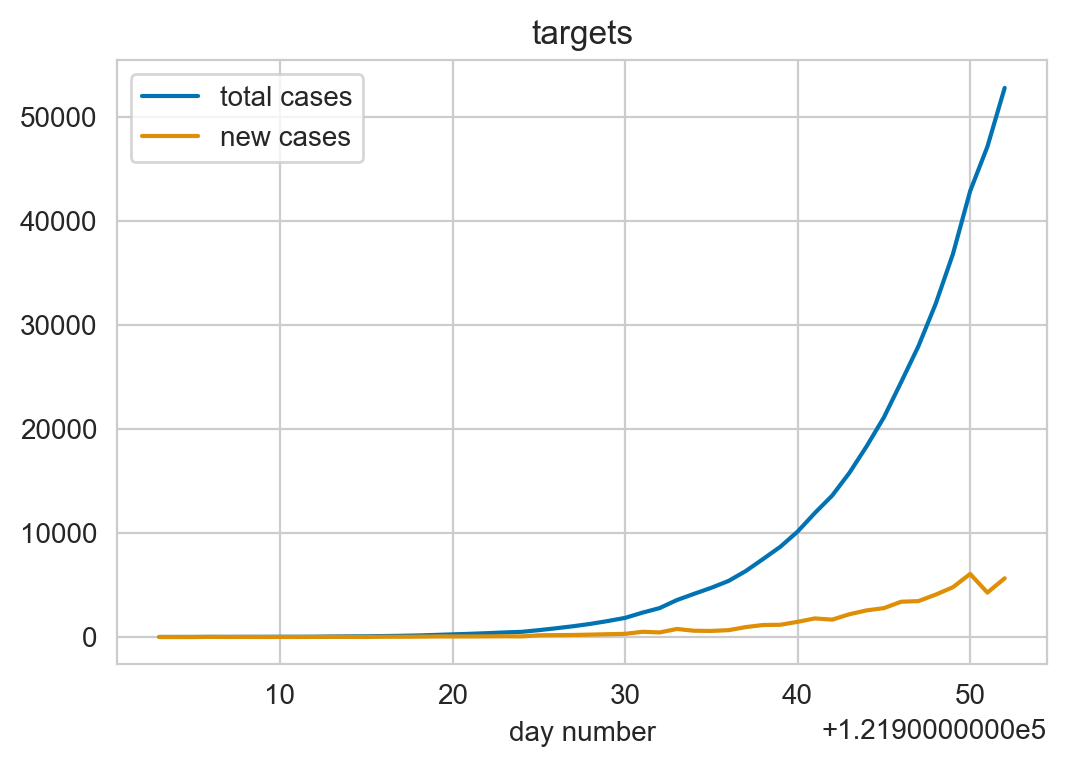

In [4]:
plt.plot(df_train['total_cases'], label='total cases')
plt.plot(df_train['new_cases'], label='new cases')
plt.title('targets')
plt.xlabel('day number')
plt.legend()
plt.grid(True)
plt.show();

### Mодель с экспоненциальным ростом числа заболевших

In [5]:
X_train = df_train[['day_number']]
y_train = df_train[['total_cases', 'new_cases']]

X_test = df_test[['day_number']]
y_test = df_test[['total_cases', 'new_cases']]

In [6]:
lr_total_cases = LinearRegression()
lr_total_cases.fit(X_train, y_train['total_cases'].apply(np.log))

lr_new_cases = LinearRegression()
lr_new_cases.fit(X_train, y_train['new_cases'].apply(np.log))

LinearRegression()

#### В качестве априорного распредения возьмем стандартное нормальное

In [7]:
mu_aprior = np.array([0, 0])
sigma_aprior = np.eye(2)

#### Параметры апостериорного распределения:

#### $\Sigma_{N}^{-1} = \Sigma_{0}^{-1} + \frac{1}{\sigma^2} X^T X$

#### $\mu_N = \Sigma_N (\Sigma_0^{-1} \mu_0 + \frac{1}{\sigma^2} X^T y)$

где $\sigma^2$ - дисперсия шума

In [8]:
def get_sigma_noise(estimator, X, y):
    return np.std(estimator.predict(X) - y)

sigma_noise_total_cases = get_sigma_noise(lr_total_cases, X_train[['day_number']], y_train['total_cases'].apply(np.log))
sigma_noise_new_cases = get_sigma_noise(lr_new_cases, X_train[['day_number']], y_train['new_cases'].apply(np.log))
print(f'sigma_noise_total_cases = {sigma_noise_total_cases}')
print(f'sigma_noise_new_cases = {sigma_noise_new_cases}')

sigma_noise_total_cases = 0.3490422059635659
sigma_noise_new_cases = 0.5960780559466519


In [9]:
X = np.stack((X_train['day_number'], np.ones(X_train.shape[0])), axis=1)

beta_total_cases = 1.0 / sigma_noise_total_cases ** 2
sigma_total_cases_post = np.linalg.inv(np.linalg.inv(sigma_aprior) + beta_total_cases * X.T @ X)
mu_total_cases_post = sigma_total_cases_post @ (np.linalg.inv(sigma_aprior) @ mu_aprior 
                                                + beta_total_cases * X.T @ y_train['total_cases'].apply(np.log))

print(f'mu_total_cases_post = {mu_total_cases_post}')
print(f'sigma_total_cases_post = {sigma_total_cases_post}')

mu_total_cases_post = [0.19876786 1.60636988]
sigma_total_cases_post = [[ 1.16121360e-05 -2.95389720e-04]
 [-2.95389720e-04  9.94481545e-03]]


In [10]:
beta_new_cases = 1.0 / sigma_noise_new_cases ** 2
sigma_new_cases_post = np.linalg.inv(np.linalg.inv(sigma_aprior) + beta_new_cases * X.T @ X)
mu_new_cases_post = sigma_new_cases_post @ (np.linalg.inv(sigma_aprior) @ mu_aprior 
                                            + beta_new_cases * X.T @ y_train['new_cases'].apply(np.log))

print(f'mu_new_cases_post = {mu_new_cases_post}')
print(f'sigma_new_cases_post = {sigma_new_cases_post}')

mu_new_cases_post = [0.18607077 0.13104732]
sigma_new_cases_post = [[ 3.33866010e-05 -8.45351109e-04]
 [-8.45351109e-04  2.84603896e-02]]


#### Построим экспоненты

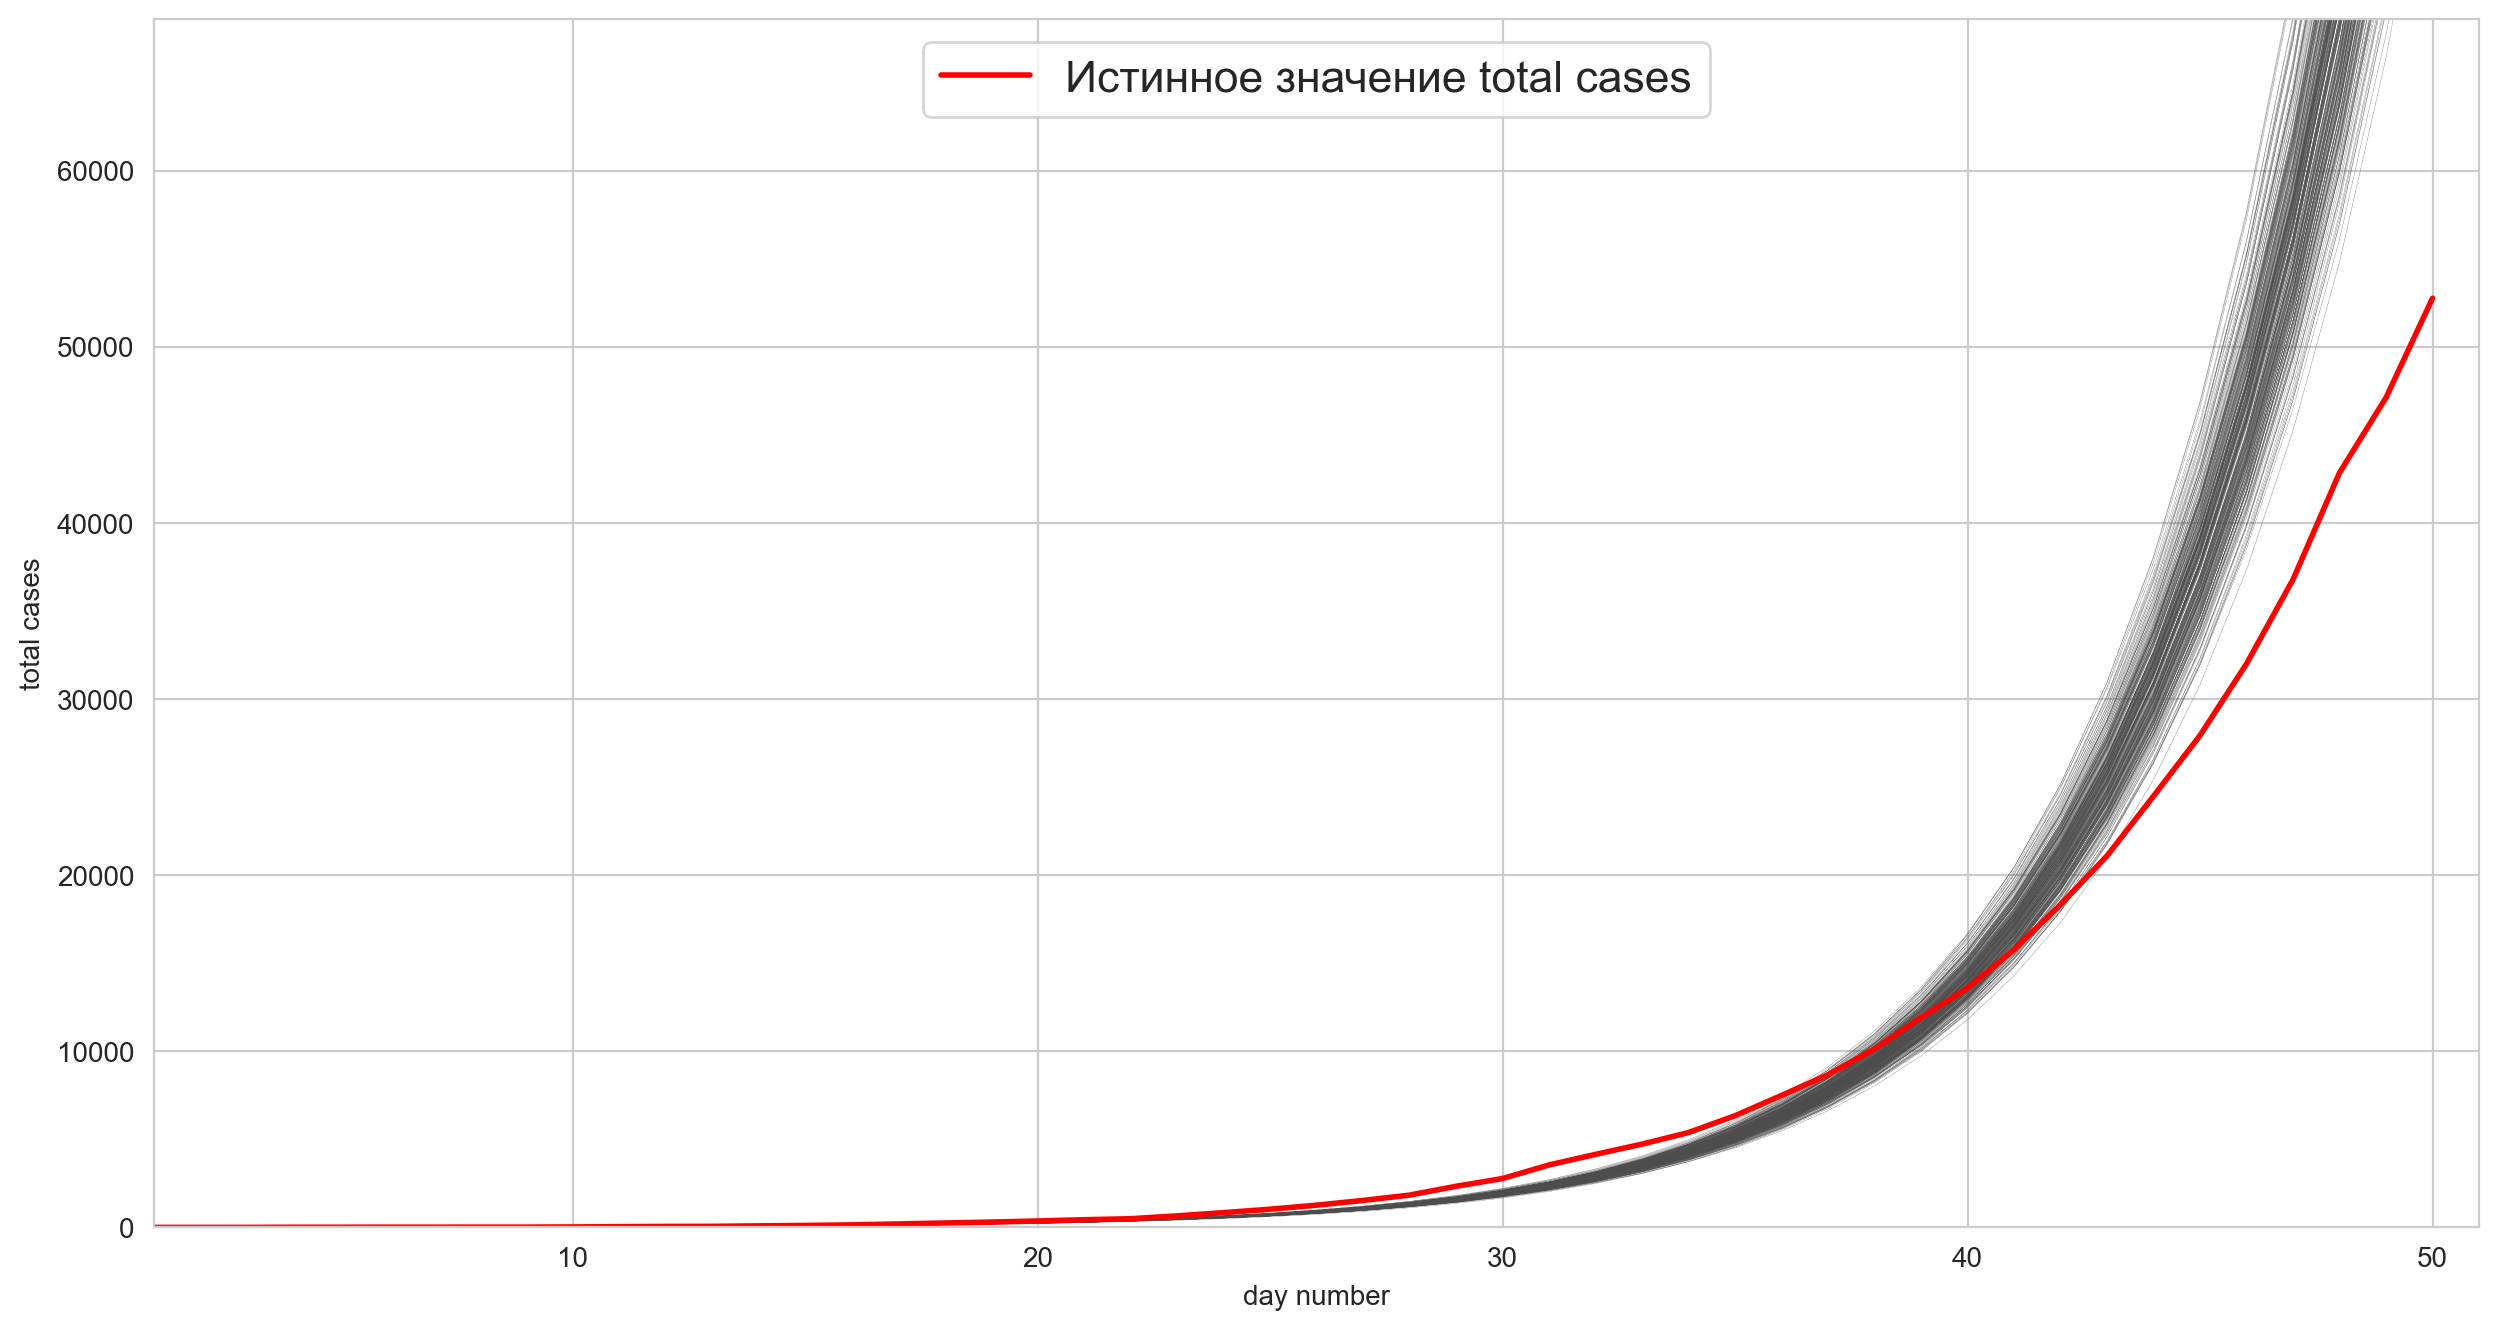

In [11]:
N = 300
xs = np.array(X_train['day_number'])
y = np.array(y_train['total_cases'])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))
ax.set_ylim((0, max(y) * 1.3))

for model_params in np.random.multivariate_normal(mu_total_cases_post, sigma_total_cases_post, size=N):
    ax.plot(xs, np.exp(model_params[0] * xs + model_params[1]), linewidth=.1, color="0.3")

ax.plot(xs, y, linewidth=2, label="Истинное значение total cases", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.xlabel('day number')
plt.ylabel('total cases')
plt.show()

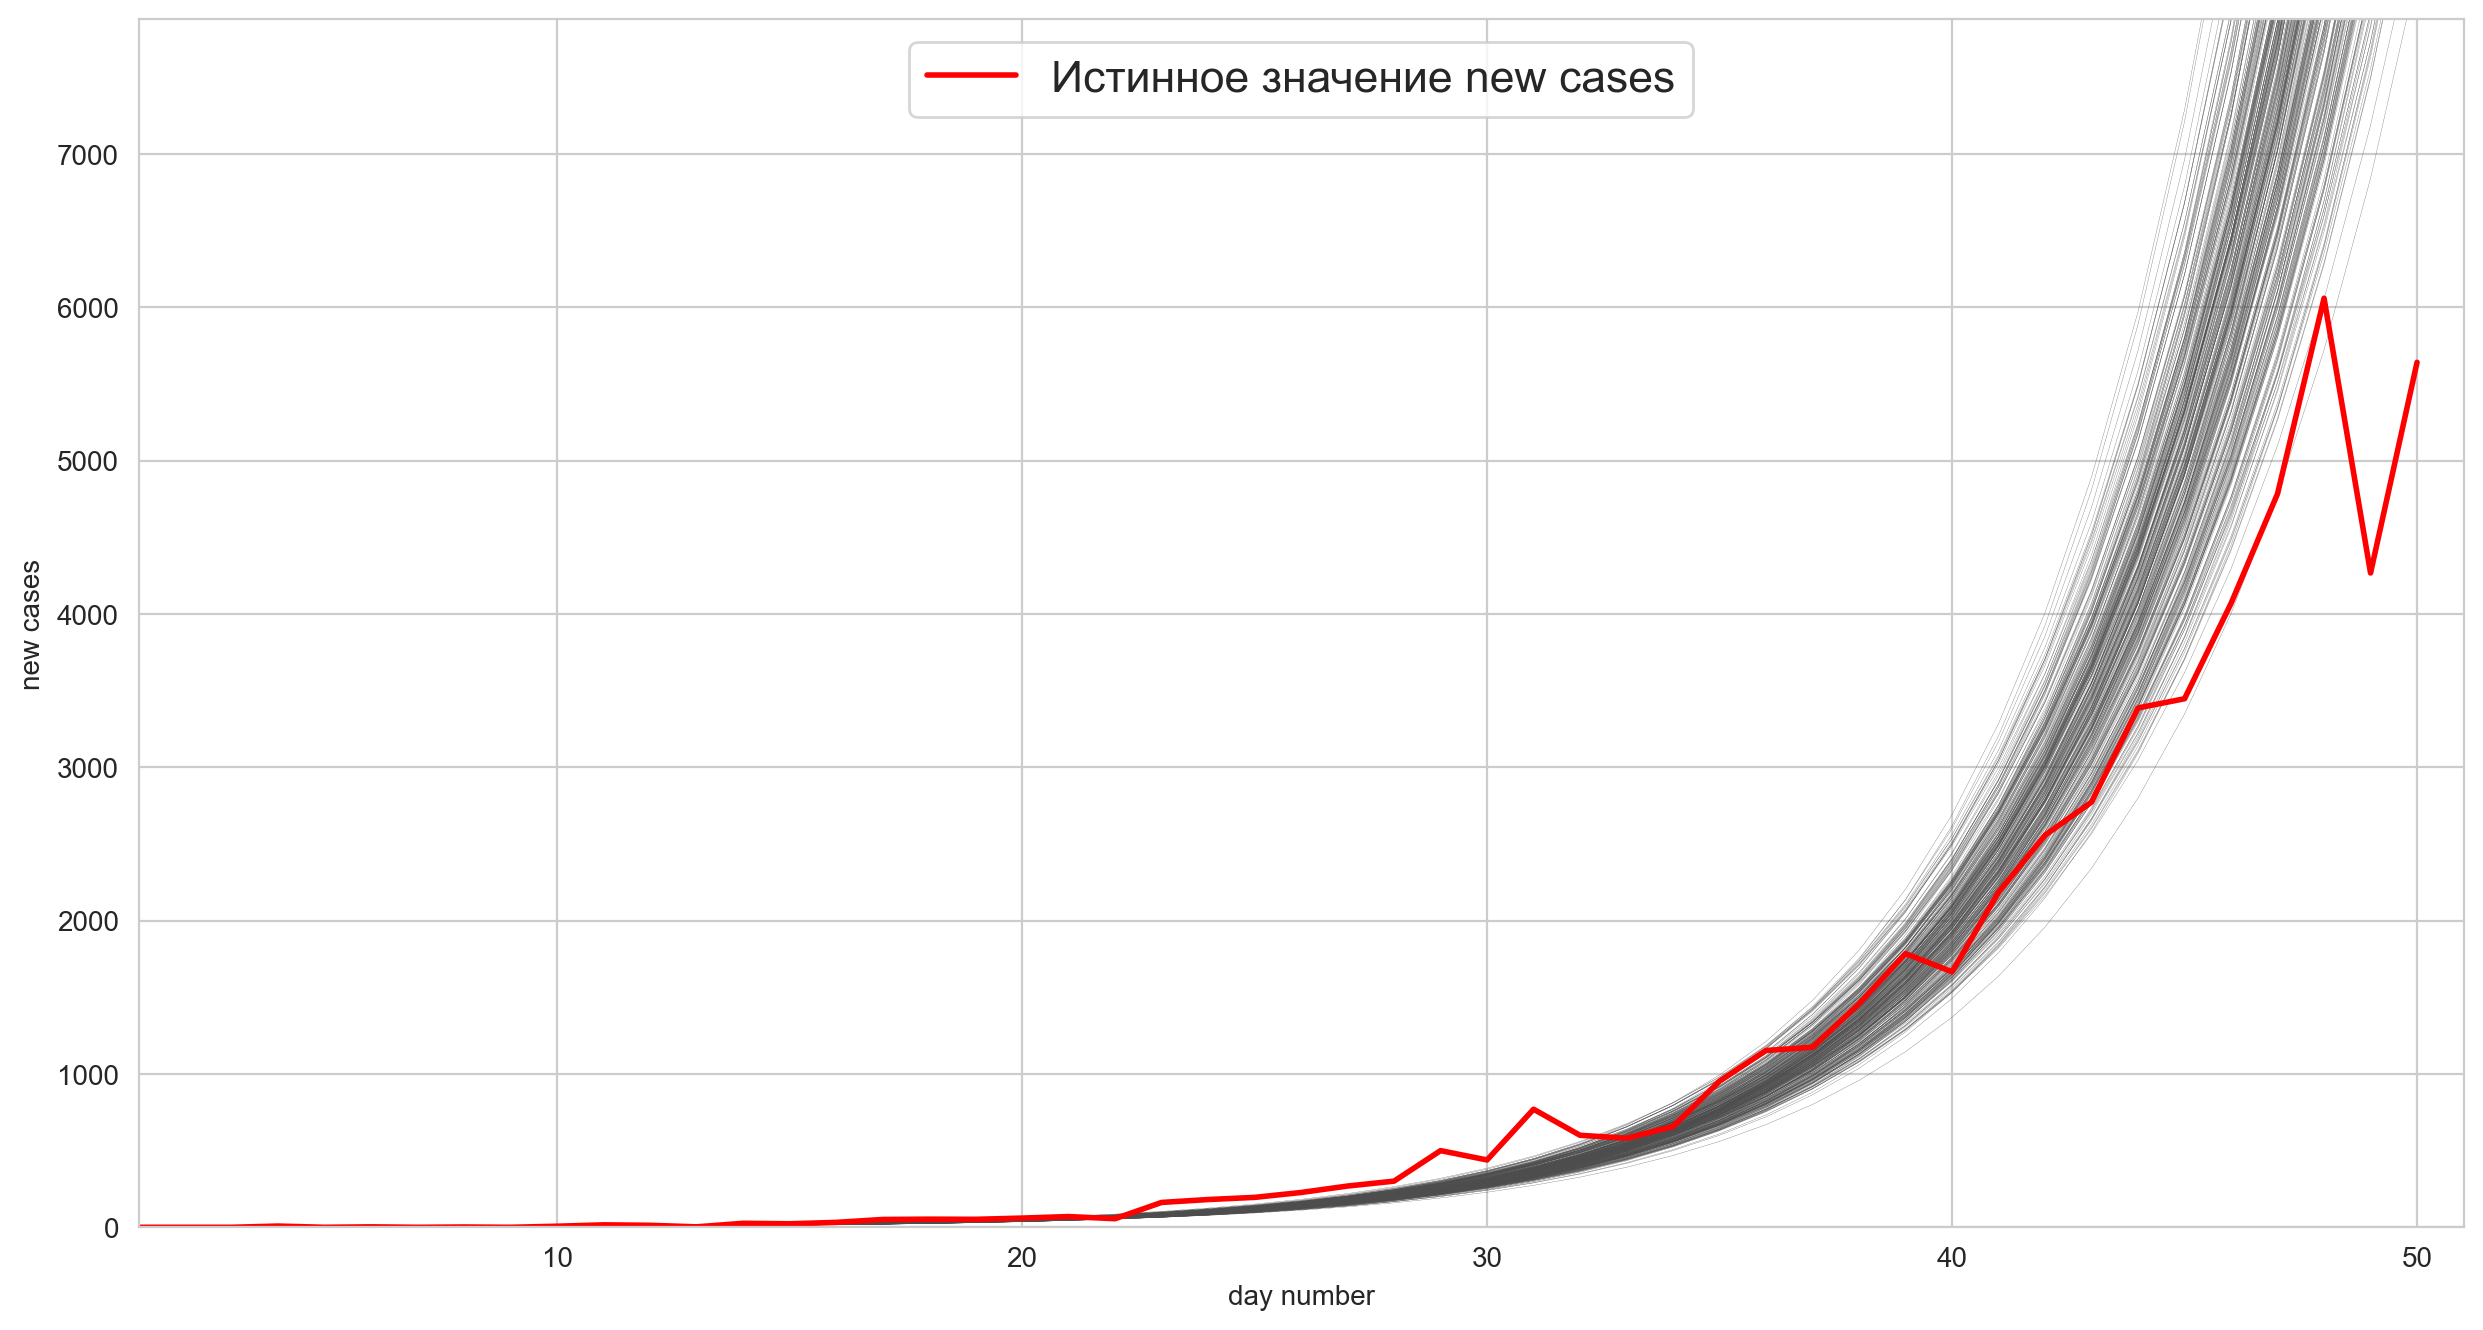

In [12]:
xs = np.array(X_train['day_number'])
y = np.array(y_train['new_cases'])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))
ax.set_ylim((0, max(y) * 1.3))

for model_params in np.random.multivariate_normal(mu_new_cases_post, sigma_new_cases_post, size=N):
    ax.plot(xs, np.exp(model_params[0] * xs + model_params[1]), linewidth=.1, color="0.3")

ax.plot(xs, y, linewidth=2, label="Истинное значение new cases", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.xlabel('day number')
plt.ylabel('new cases')
plt.show()

#### Видим, что модель предсказывает излишне большое число зараженных, как total, так и new

#### Если попытаться посмотреть на тесте, то разница будет уже просто катастрофическая

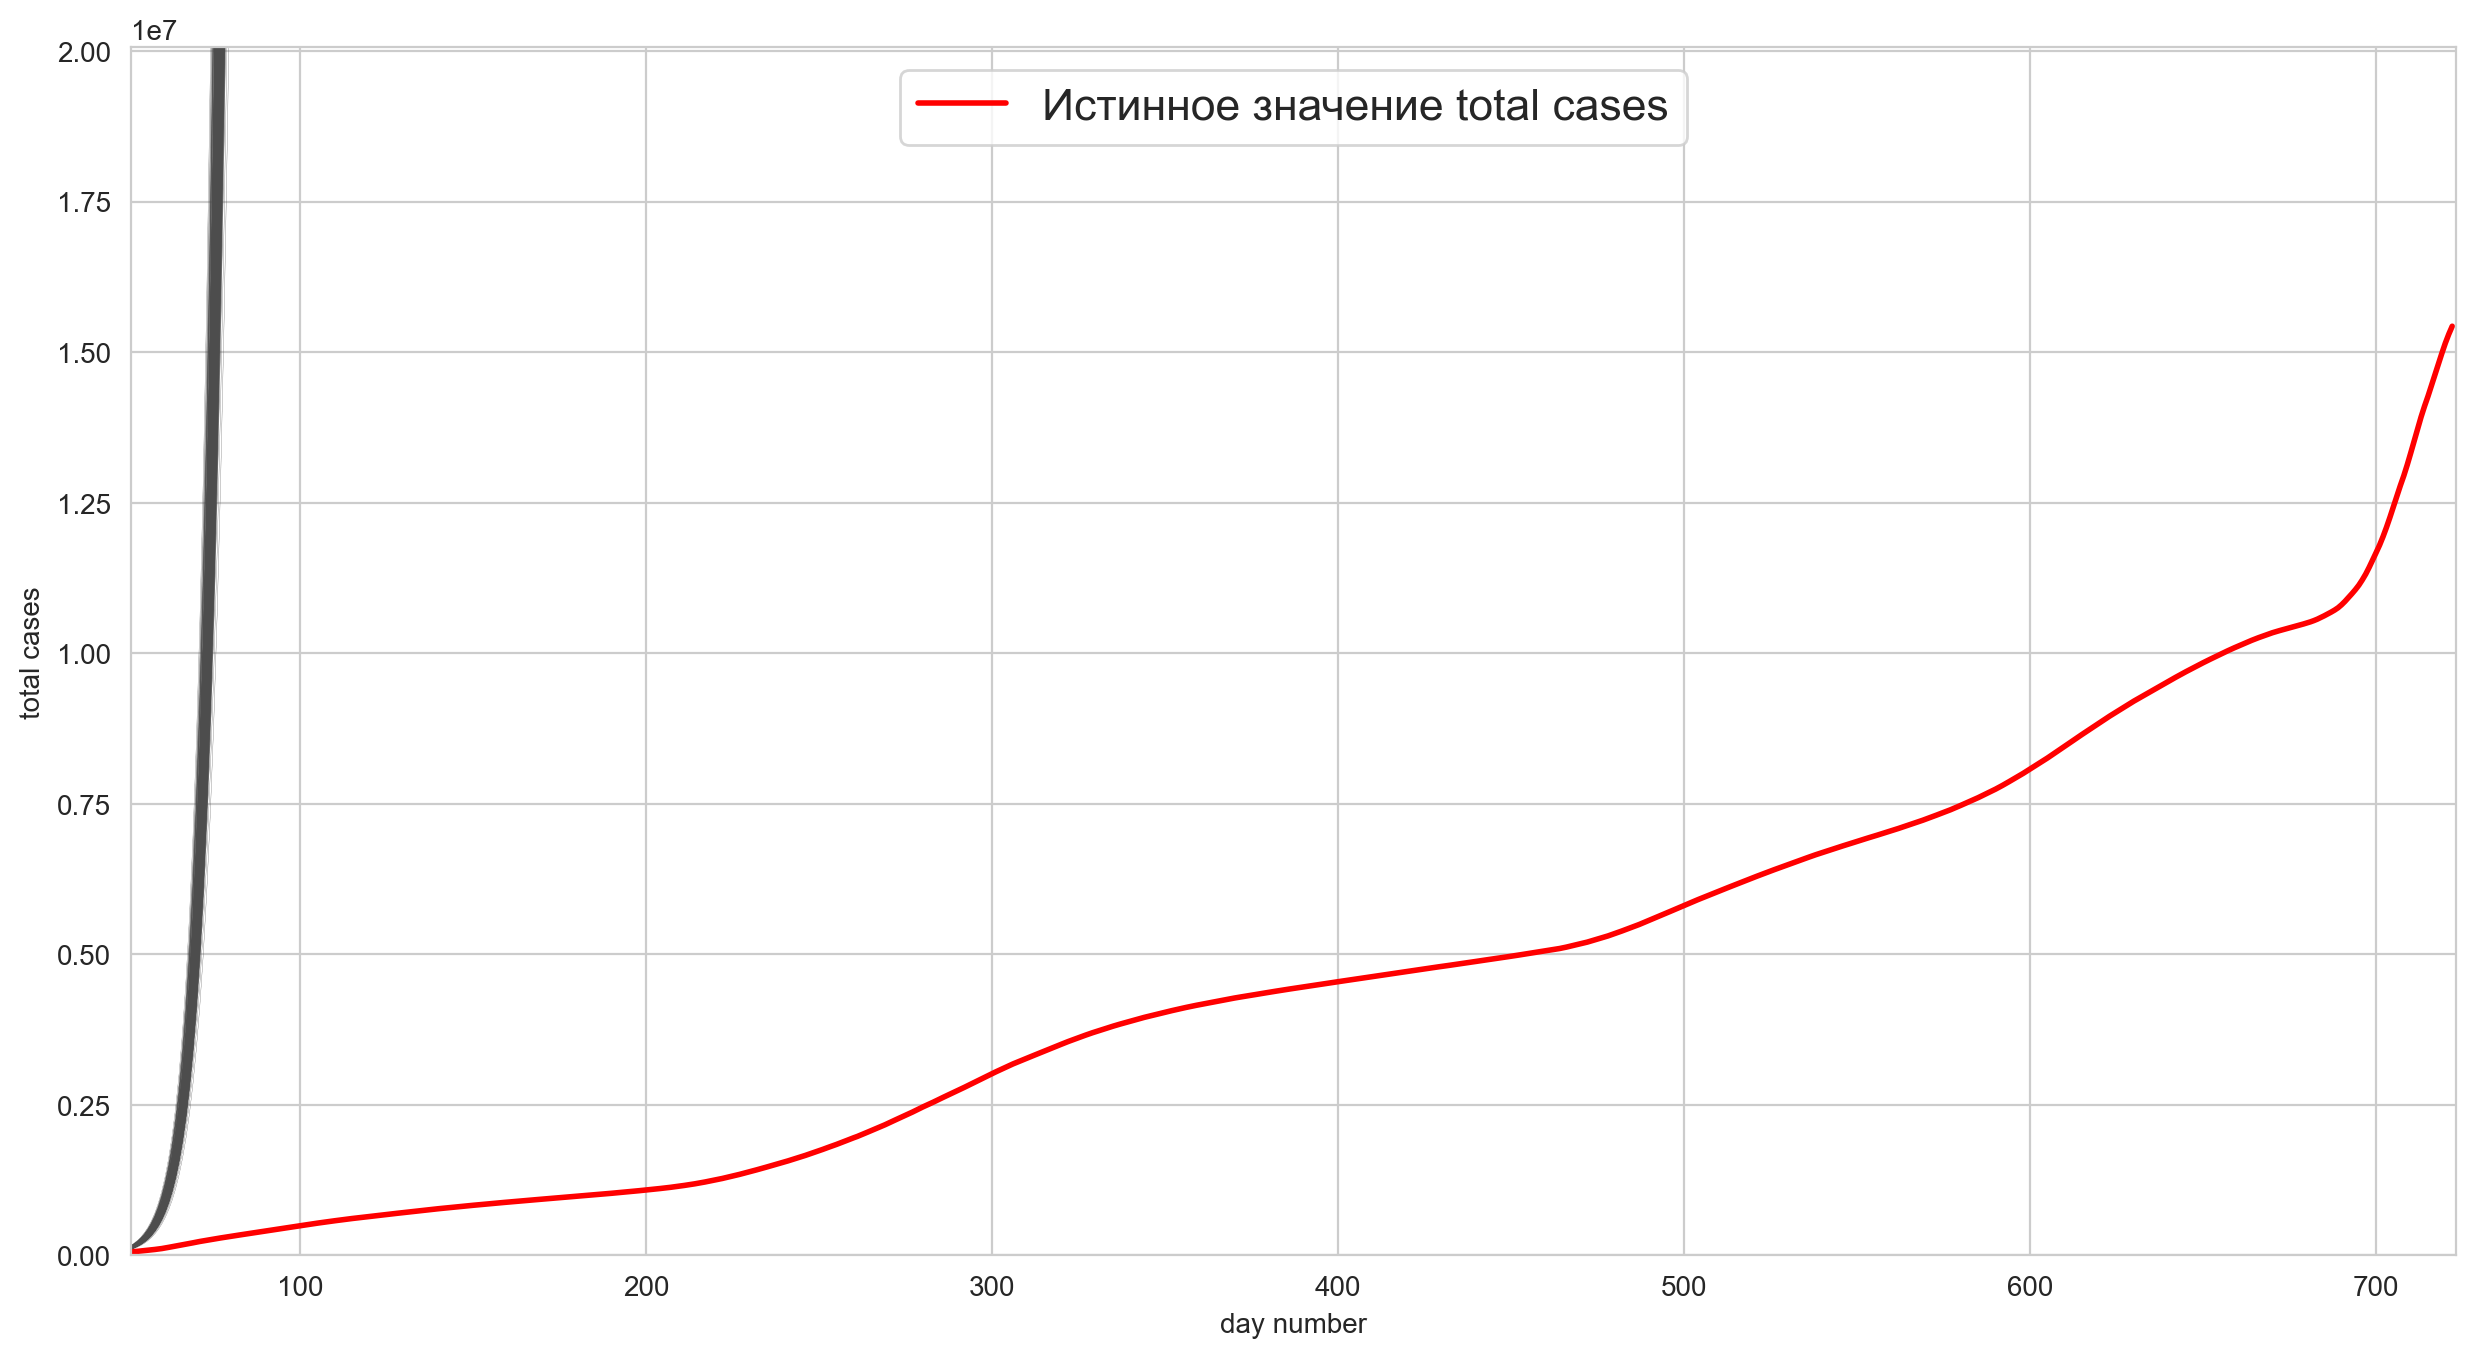

In [13]:
N = 300
xs = np.array(X_test['day_number'])
y = np.array(y_test['total_cases'])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))
ax.set_ylim((0, max(y) * 1.3))

for model_params in np.random.multivariate_normal(mu_total_cases_post, sigma_total_cases_post, size=N):
    ax.plot(xs, np.exp(model_params[0] * xs + model_params[1]), linewidth=.1, color="0.3")

ax.plot(xs, y, linewidth=2, label="Истинное значение total cases", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.xlabel('day number')
plt.ylabel('total cases')
plt.show()

### Эмпирическое предсказательное распределение

In [14]:
def predict_distribution_at_day(mu, sigma, day, target, size=10000):
    model_params = np.random.multivariate_normal(mu, sigma, size)
    y = np.exp(model_params[:,1] + model_params[:,0] * day)
    plt.figure(figsize=figsize)
    plt.hist(y, bins=100, density=True)
    plt.grid(True)
    plt.xlabel(target)
    plt.title(f'{target} disctribution')
    return list(map(int, np.quantile(y, [0.1, 0.5, 0.9])))

на 1 мая:

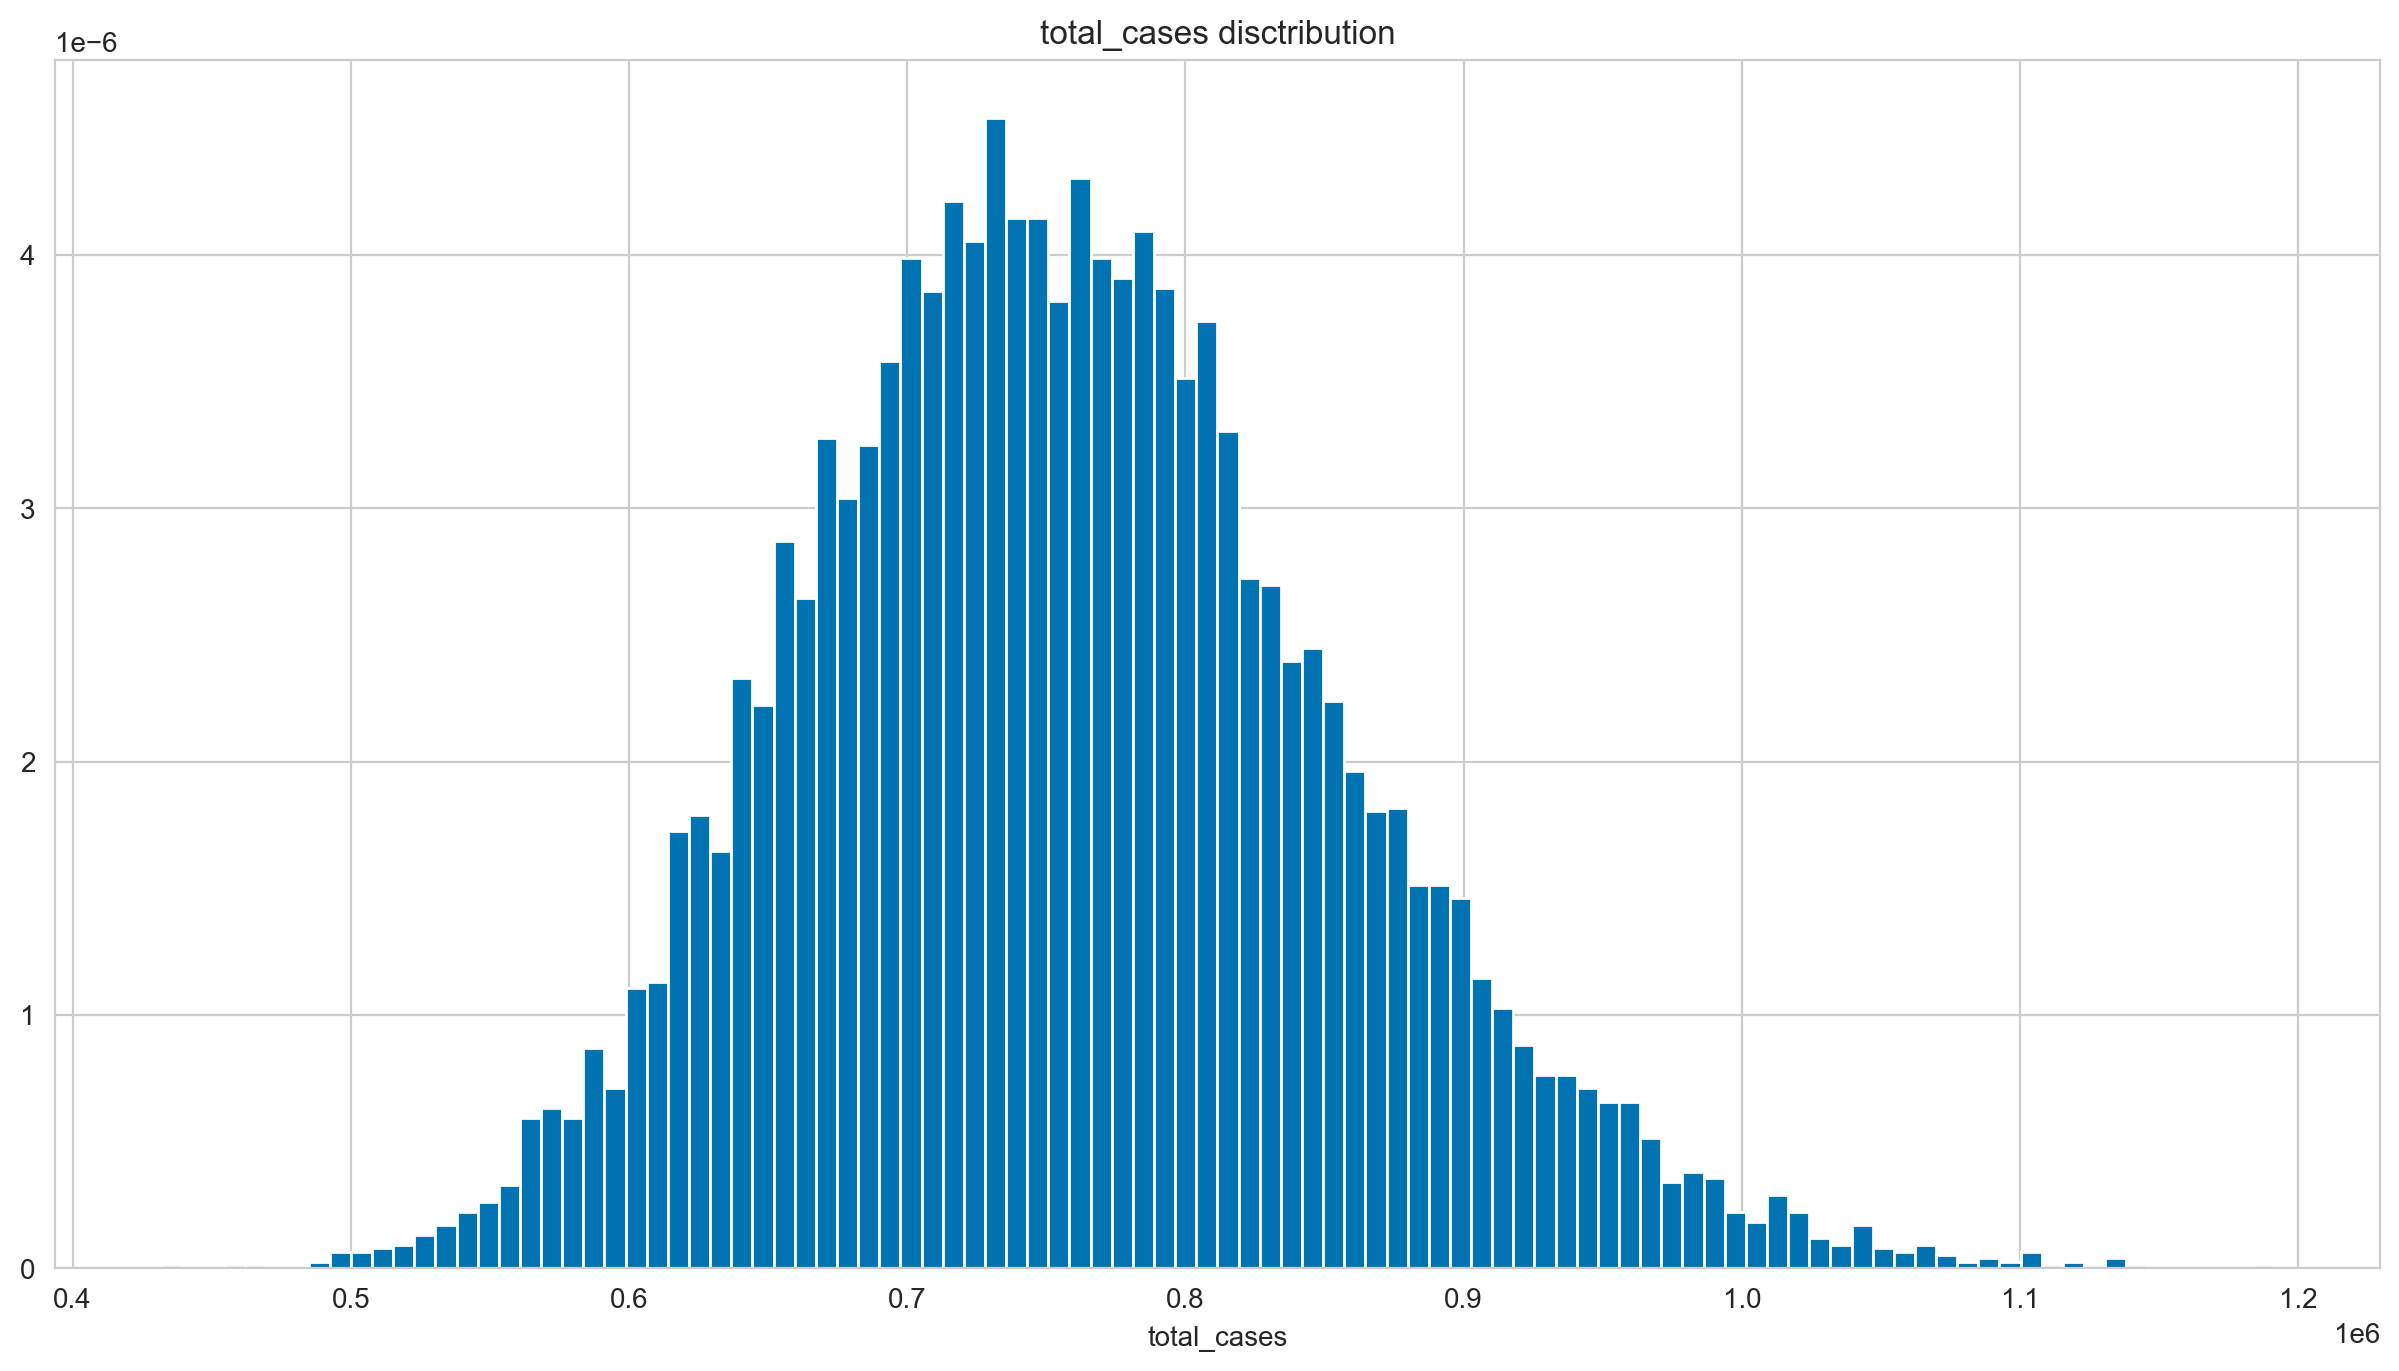

In [15]:
prediction_stat = predict_distribution_at_day(mu_total_cases_post, sigma_total_cases_post, 
                                              day=df[df['date'] == '2020-05-01']['day_number'].values[0],
                                              target='total_cases')

In [16]:
print(f'Оптимистический прогноз на 01.05.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.05.2020: {prediction_stat[1]} total cases')
print(f'Пессиместический прогноз на 01.05.2020: {prediction_stat[2]} total cases')

Оптимистический прогноз на 01.05.2020: 639683 total cases
Средний прогноз на 01.05.2020: 753431 total cases
Пессиместический прогноз на 01.05.2020: 886526 total cases


Оптимистический прогноз на 01.06.2020: 266916698 total cases
Средний прогноз на 01.06.2020: 355667830 total cases
Пессиместический прогноз на 01.06.2020: 480280891 total cases


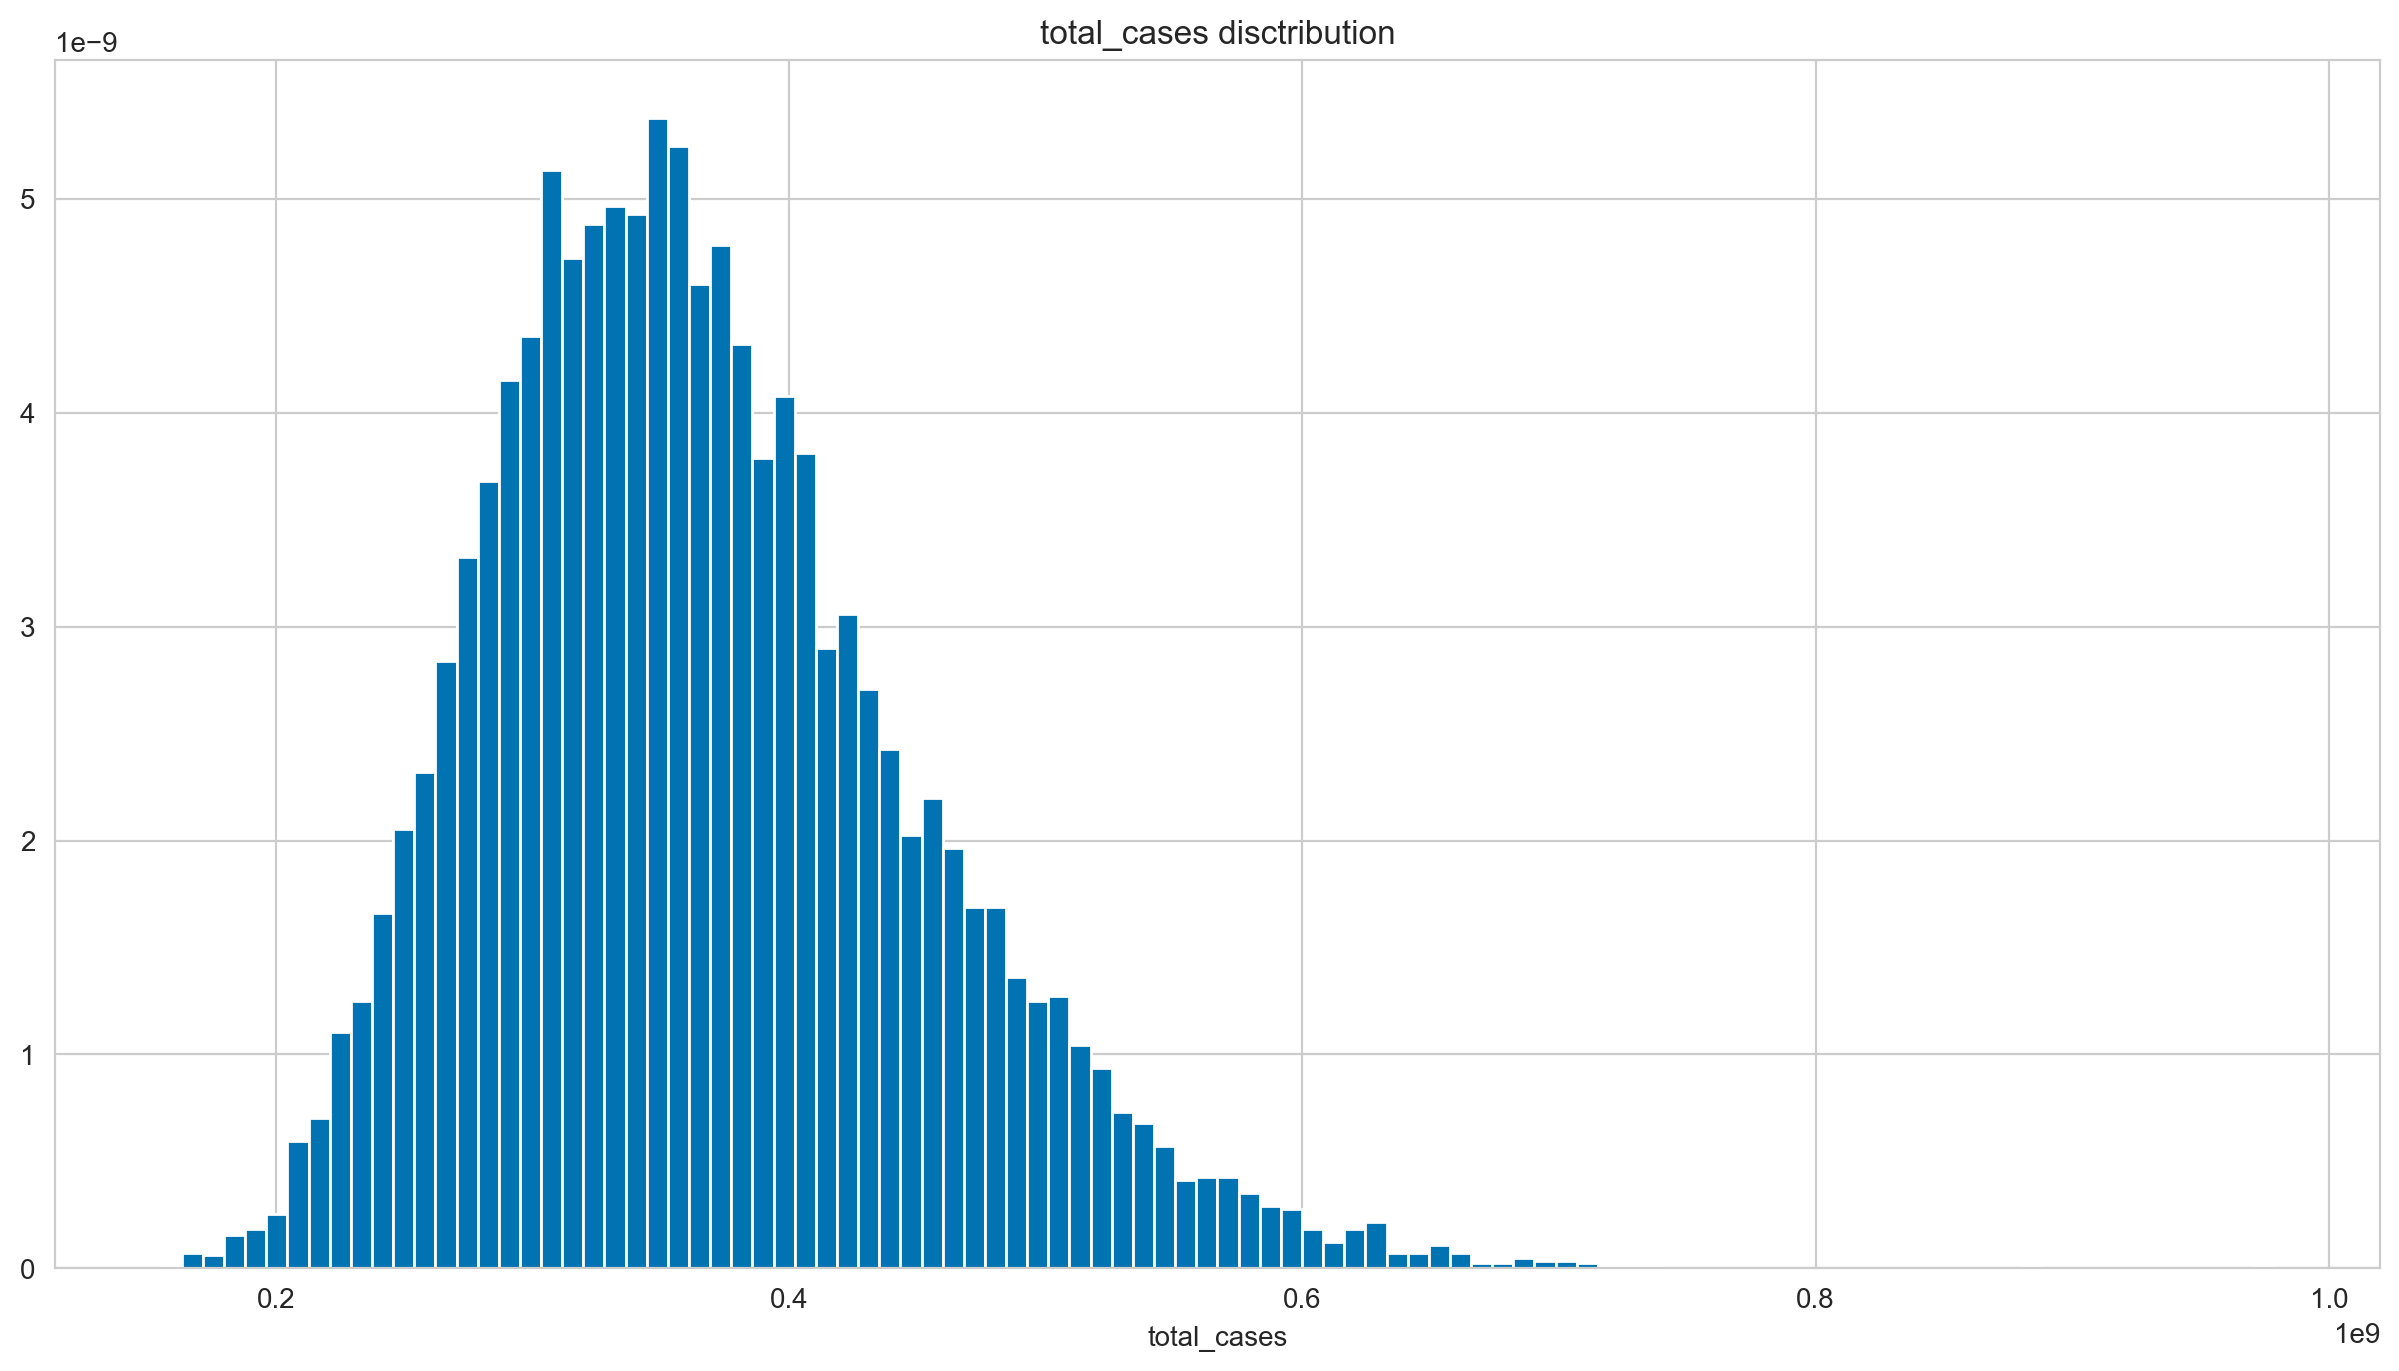

In [17]:
prediction_stat = predict_distribution_at_day(mu_total_cases_post, sigma_total_cases_post, 
                                              day=df[df['date'] == '2020-06-01']['day_number'].values[0],
                                              target='total_cases')

print(f'Оптимистический прогноз на 01.06.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.06.2020: {prediction_stat[1]} total cases')
print(f'Пессиместический прогноз на 01.06.2020: {prediction_stat[2]} total cases')

Оптимистический прогноз на 01.09.2020: 15626893032544032 total cases
Средний прогноз на 01.09.2020: 31473046562557604 total cases
Пессимистический прогноз на 01.09.2020: 62328547406964256 total cases


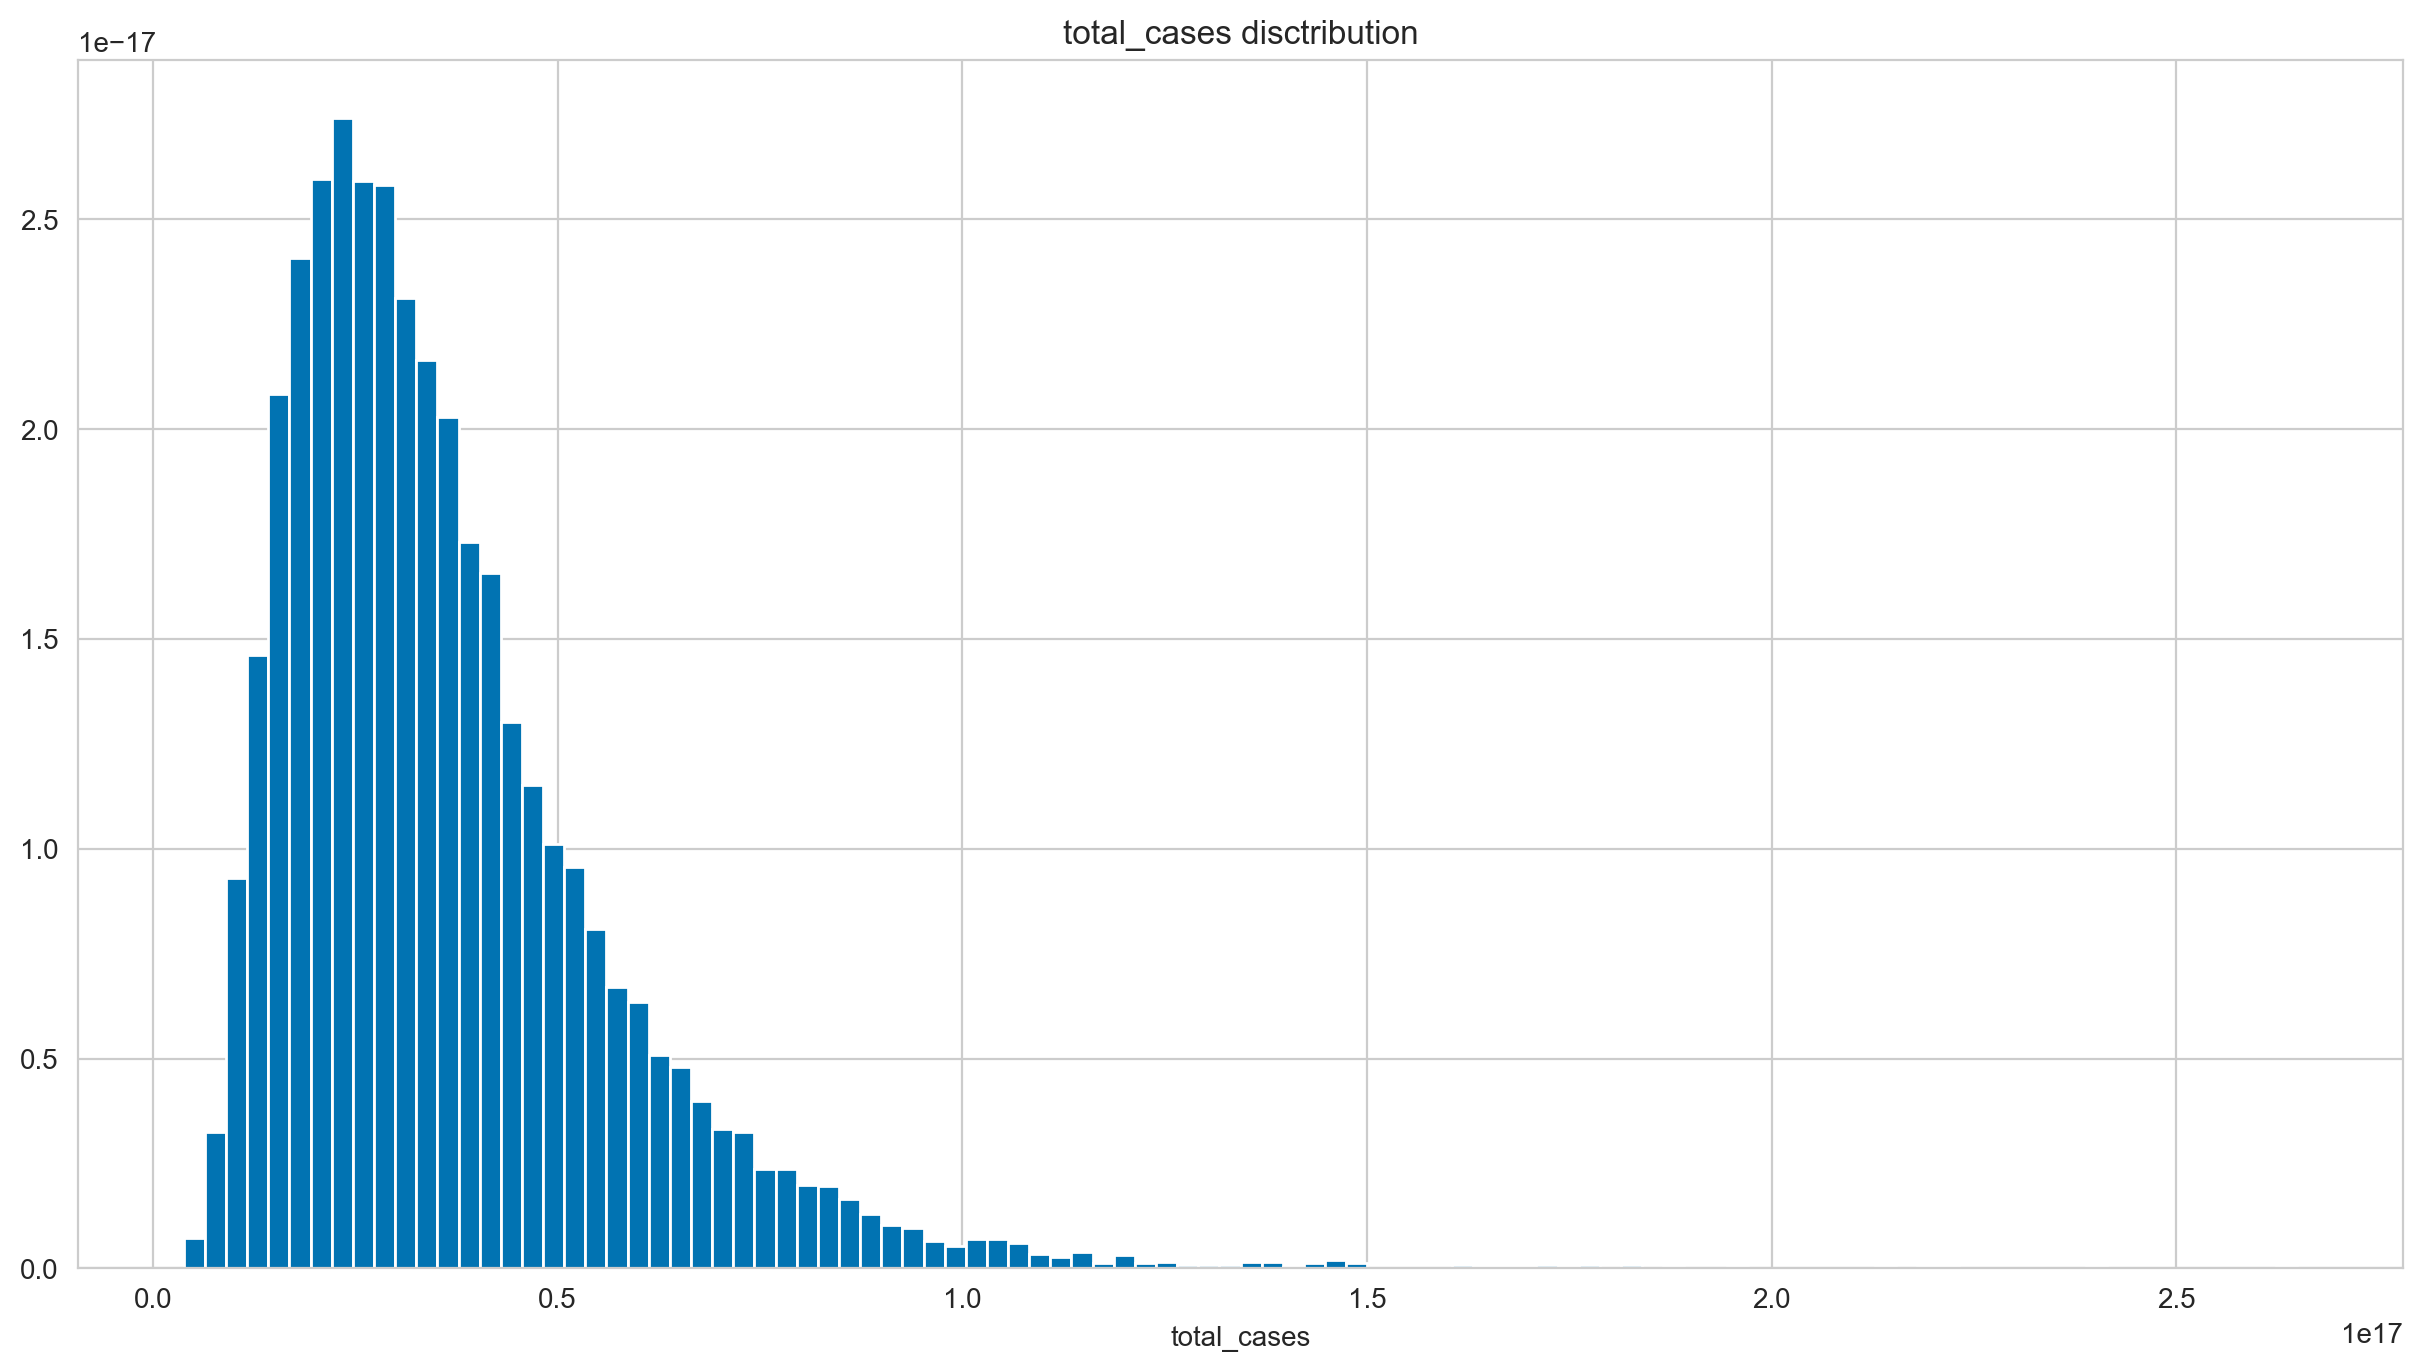

In [18]:
prediction_stat = predict_distribution_at_day(mu_total_cases_post, sigma_total_cases_post, 
                                              day=df[df['date'] == '2020-09-01']['day_number'].values[0],
                                              target='total_cases')

print(f'Оптимистический прогноз на 01.09.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.09.2020: {prediction_stat[1]} total cases')
print(f'Пессимистический прогноз на 01.09.2020: {prediction_stat[2]} total cases')

Т.е согласно этой модели уже к 1 июня 2020 года должно переболеть все население России, что очевидно не так. К 1 сентября предсказание уже во много раз превышает население Земли

### Пробуем улучшить модель с помощью сигмоиды

По условию после внесения константы под интеграл имеем:

$$\Phi(x) = \int_{-\infty}^{x} e^{w_2 t^2 + w_1 t + w_0} dt$$

Чтобы теперь работать степенью экспоненты, которая как раз является линейной функцией по $w_i$ (а это то, что нам надо), продифференцируем правую и левую часть и перейдем к логарифму:

$$\log\dfrac{d\Phi}{dx} = w_2 t^2 + w_1 t + w_0$$

Нам понадобятся вспомогательные функции для приближенного вычисления производной и восстановлению по производной исходных значений:

In [19]:
def grad(array):
    return np.gradient(array)

In [20]:
def integrate(init_point, array):
    return init_point + 2 * np.c_[np.r_[0, array[1: -1: 2].cumsum()], array[:: 2].cumsum() - array[0] / 2].ravel()[: len(array)]

Проверим, что все работает корректно, т.е. если мы посчитаем приближенно производную, а потом проинтегрируем, то получим исходный массив 

In [21]:
for _ in range(100):
    test_array = np.random.random(1000)
    assert np.allclose(test_array, integrate(test_array[0], grad(test_array)))

Теперь легко написать функции преобразования таргета

In [22]:
def transform_target(y_train, target):
    eps = 1e-6
    grad_data = grad(y_train[target].values)
    grad_data[grad_data <= 0] = eps
    return np.log(grad_data)

In [23]:
def restore_target(y_train, target, transformed_target):
    target_data = np.exp(transformed_target)
    return integrate(y_train[target].values[0], target_data)

Теперь можно обучить модель, учитывая, что теперь еще добавился признак day_number^2

In [24]:
X = np.stack((X_train['day_number'] ** 2, X_train['day_number'], np.ones(X_train.shape[0])), axis=1)

In [25]:
lr_total_cases = LinearRegression()
lr_total_cases.fit(X, transform_target(y_train, 'total_cases'));

In [26]:
lr_new_cases = LinearRegression()
lr_new_cases.fit(X, transform_target(y_train, 'new_cases'));

Так же, как и ранее, в качестве априорного возьмем стандартное нормальное распределение

In [27]:
mu_aprior = np.array([0, 0, 0])
sigma_aprior = np.eye(3)

Так же, как и ранее, найдем параметры апостериорного распределения

In [28]:
sigma_noise_total_cases = get_sigma_noise(lr_total_cases, X, transform_target(y_train, 'total_cases'))
print(f'sigma_noise_total_cases = {sigma_noise_total_cases}')

sigma_noise_total_cases = 1.7836665678359327


In [29]:
beta_total_cases = 1.0 / sigma_noise_total_cases ** 2
sigma_total_cases_post = np.linalg.inv(np.linalg.inv(sigma_aprior) + beta_total_cases * X.T @ X)
mu_total_cases_post = sigma_total_cases_post @ (np.linalg.inv(sigma_aprior) @ mu_aprior
                                                + beta_total_cases * X.T @ transform_target(y_train, 'total_cases'))

print(f'mu_total_cases_post = {mu_total_cases_post}')
print(f'sigma_total_cases_post = {sigma_total_cases_post}')

mu_total_cases_post = [-0.00351927  0.38066507 -1.854667  ]
sigma_total_cases_post = [[ 1.42510639e-06 -6.87748070e-05  4.98579465e-04]
 [-6.87748070e-05  3.57641846e-03 -3.02318657e-02]
 [ 4.98579465e-04 -3.02318657e-02  3.82192765e-01]]


#### Посемплируем сигмоиды из апостериорного распределения

##### Сначала на трейне

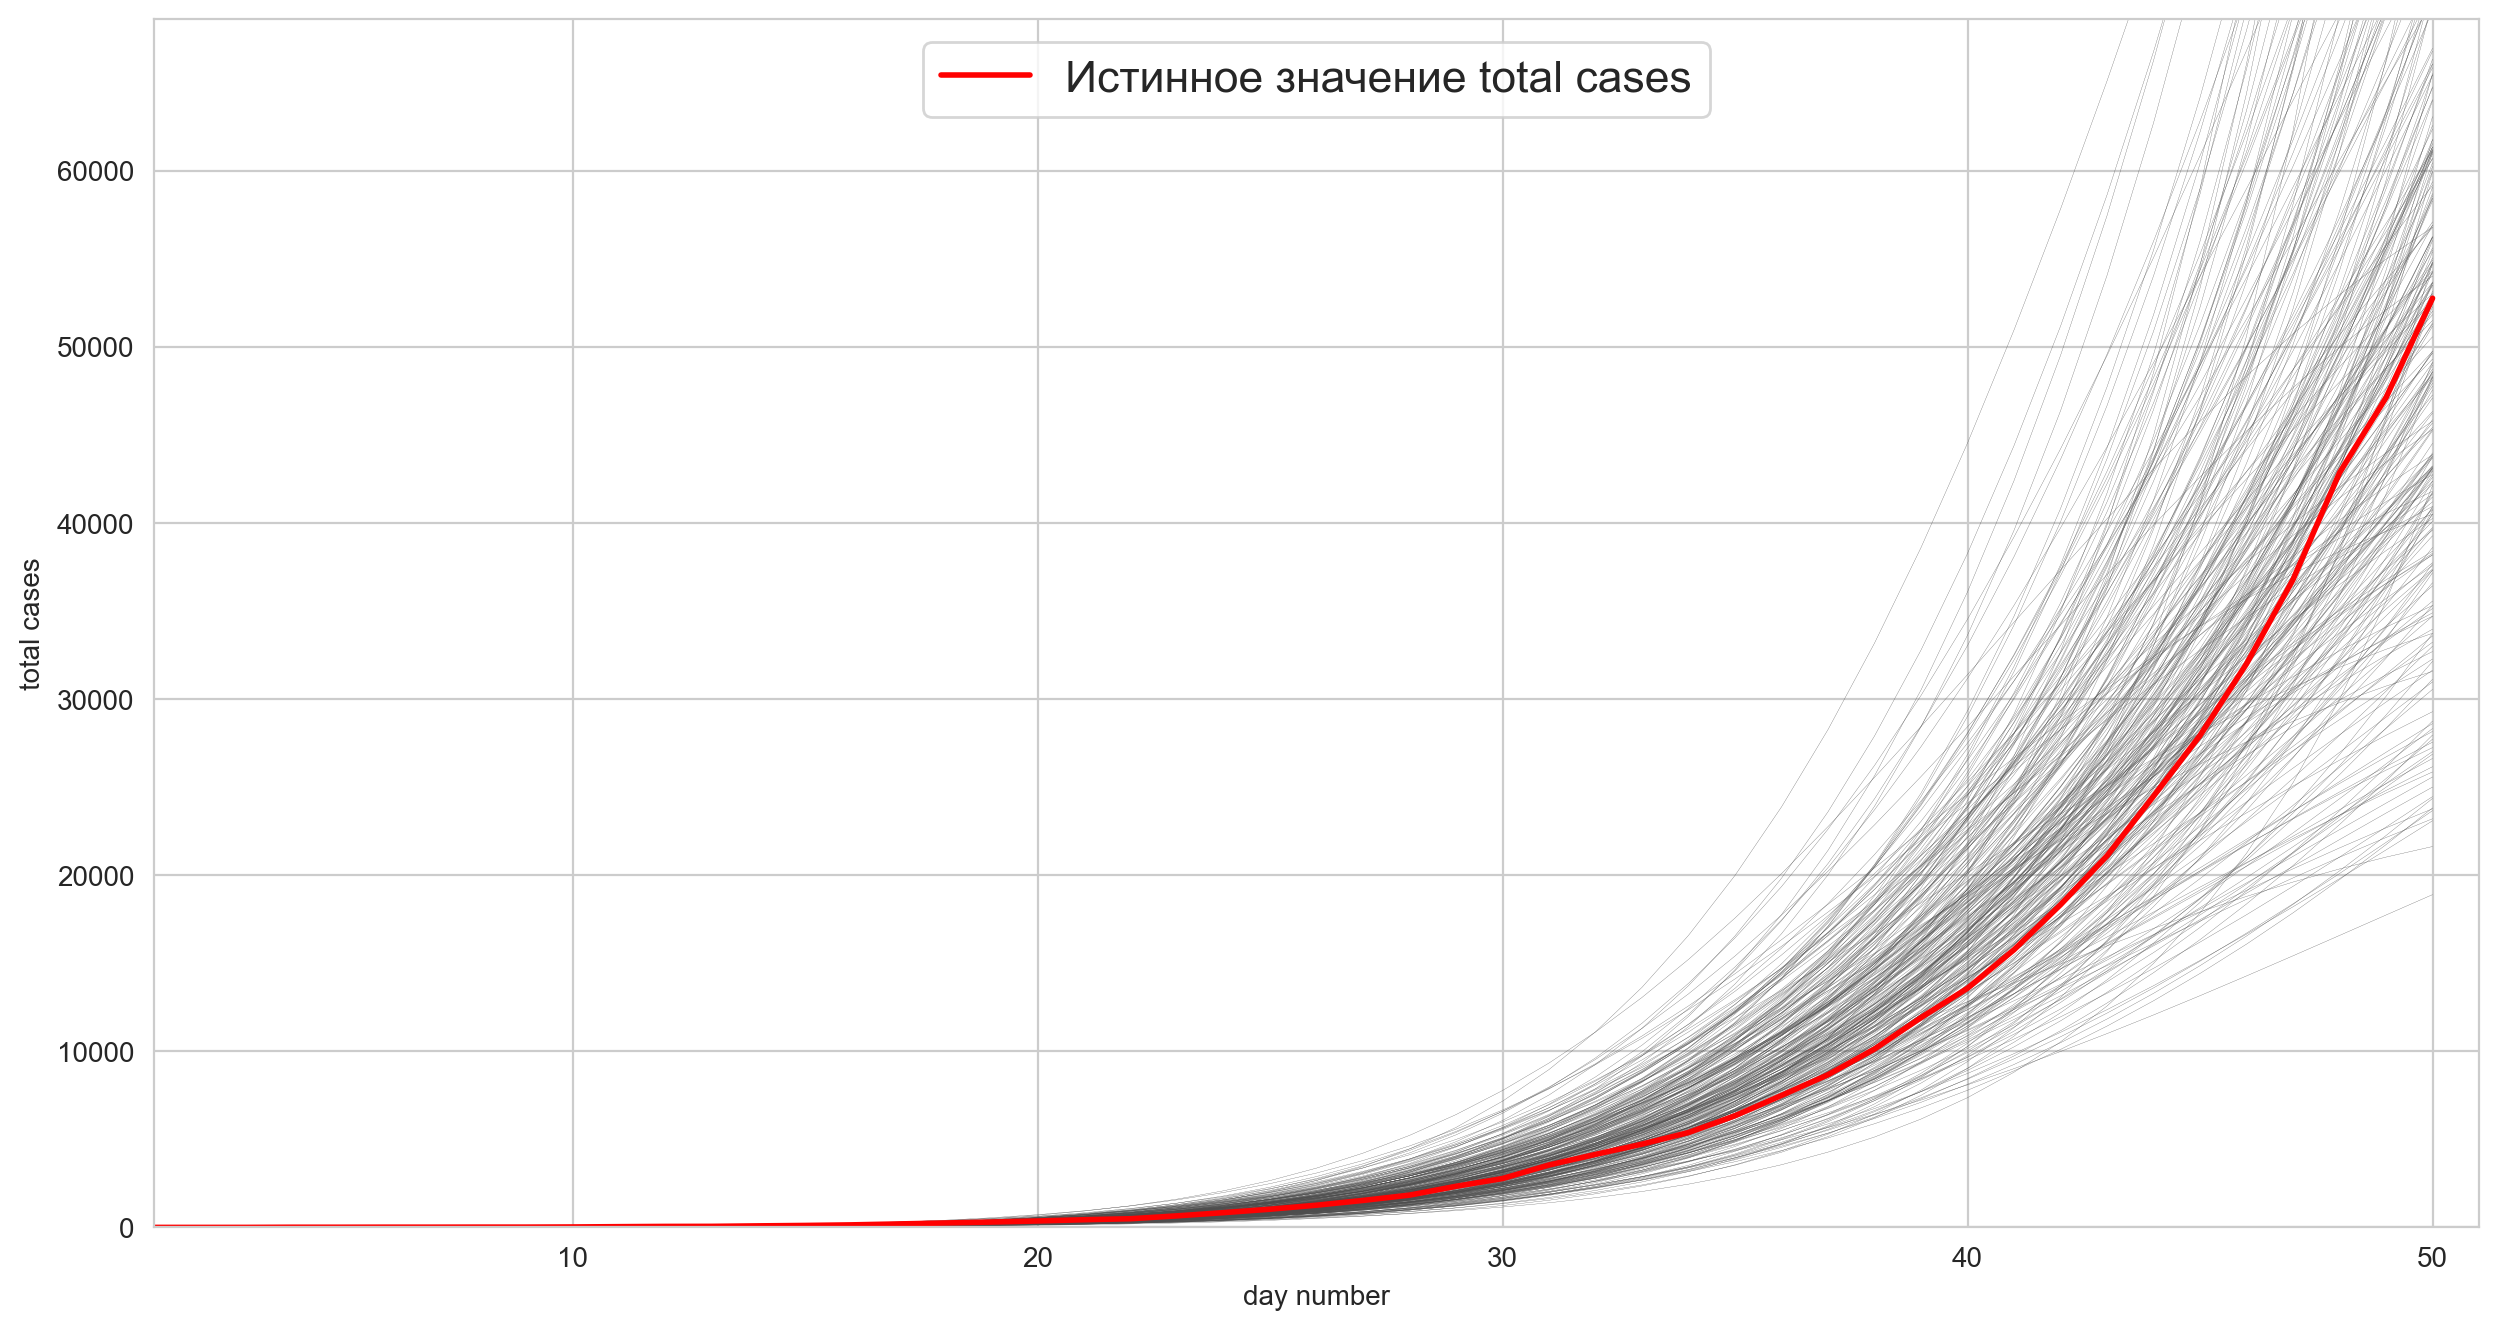

In [30]:
N = 300
xs = np.array(X_train['day_number'])
y = np.array(y_train['total_cases'])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))
ax.set_ylim((0, max(y) * 1.3))

for model_params in np.random.multivariate_normal(mu_total_cases_post, sigma_total_cases_post, size=N):
    current_pred = model_params[0] * xs ** 2 + model_params[1] * xs + model_params[2]
    ax.plot(xs, restore_target(y_train, 'total_cases', current_pred), linewidth=.1, color="0.3")

ax.plot(xs, y, linewidth=2, label="Истинное значение total cases", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.xlabel('day number')
plt.ylabel('total cases')
plt.show()

Видим, что на трейне уже получаем более адекватный результат, чем при моделировании сигмоидой.

Теперь посмотрим на более продолжительном интервале:

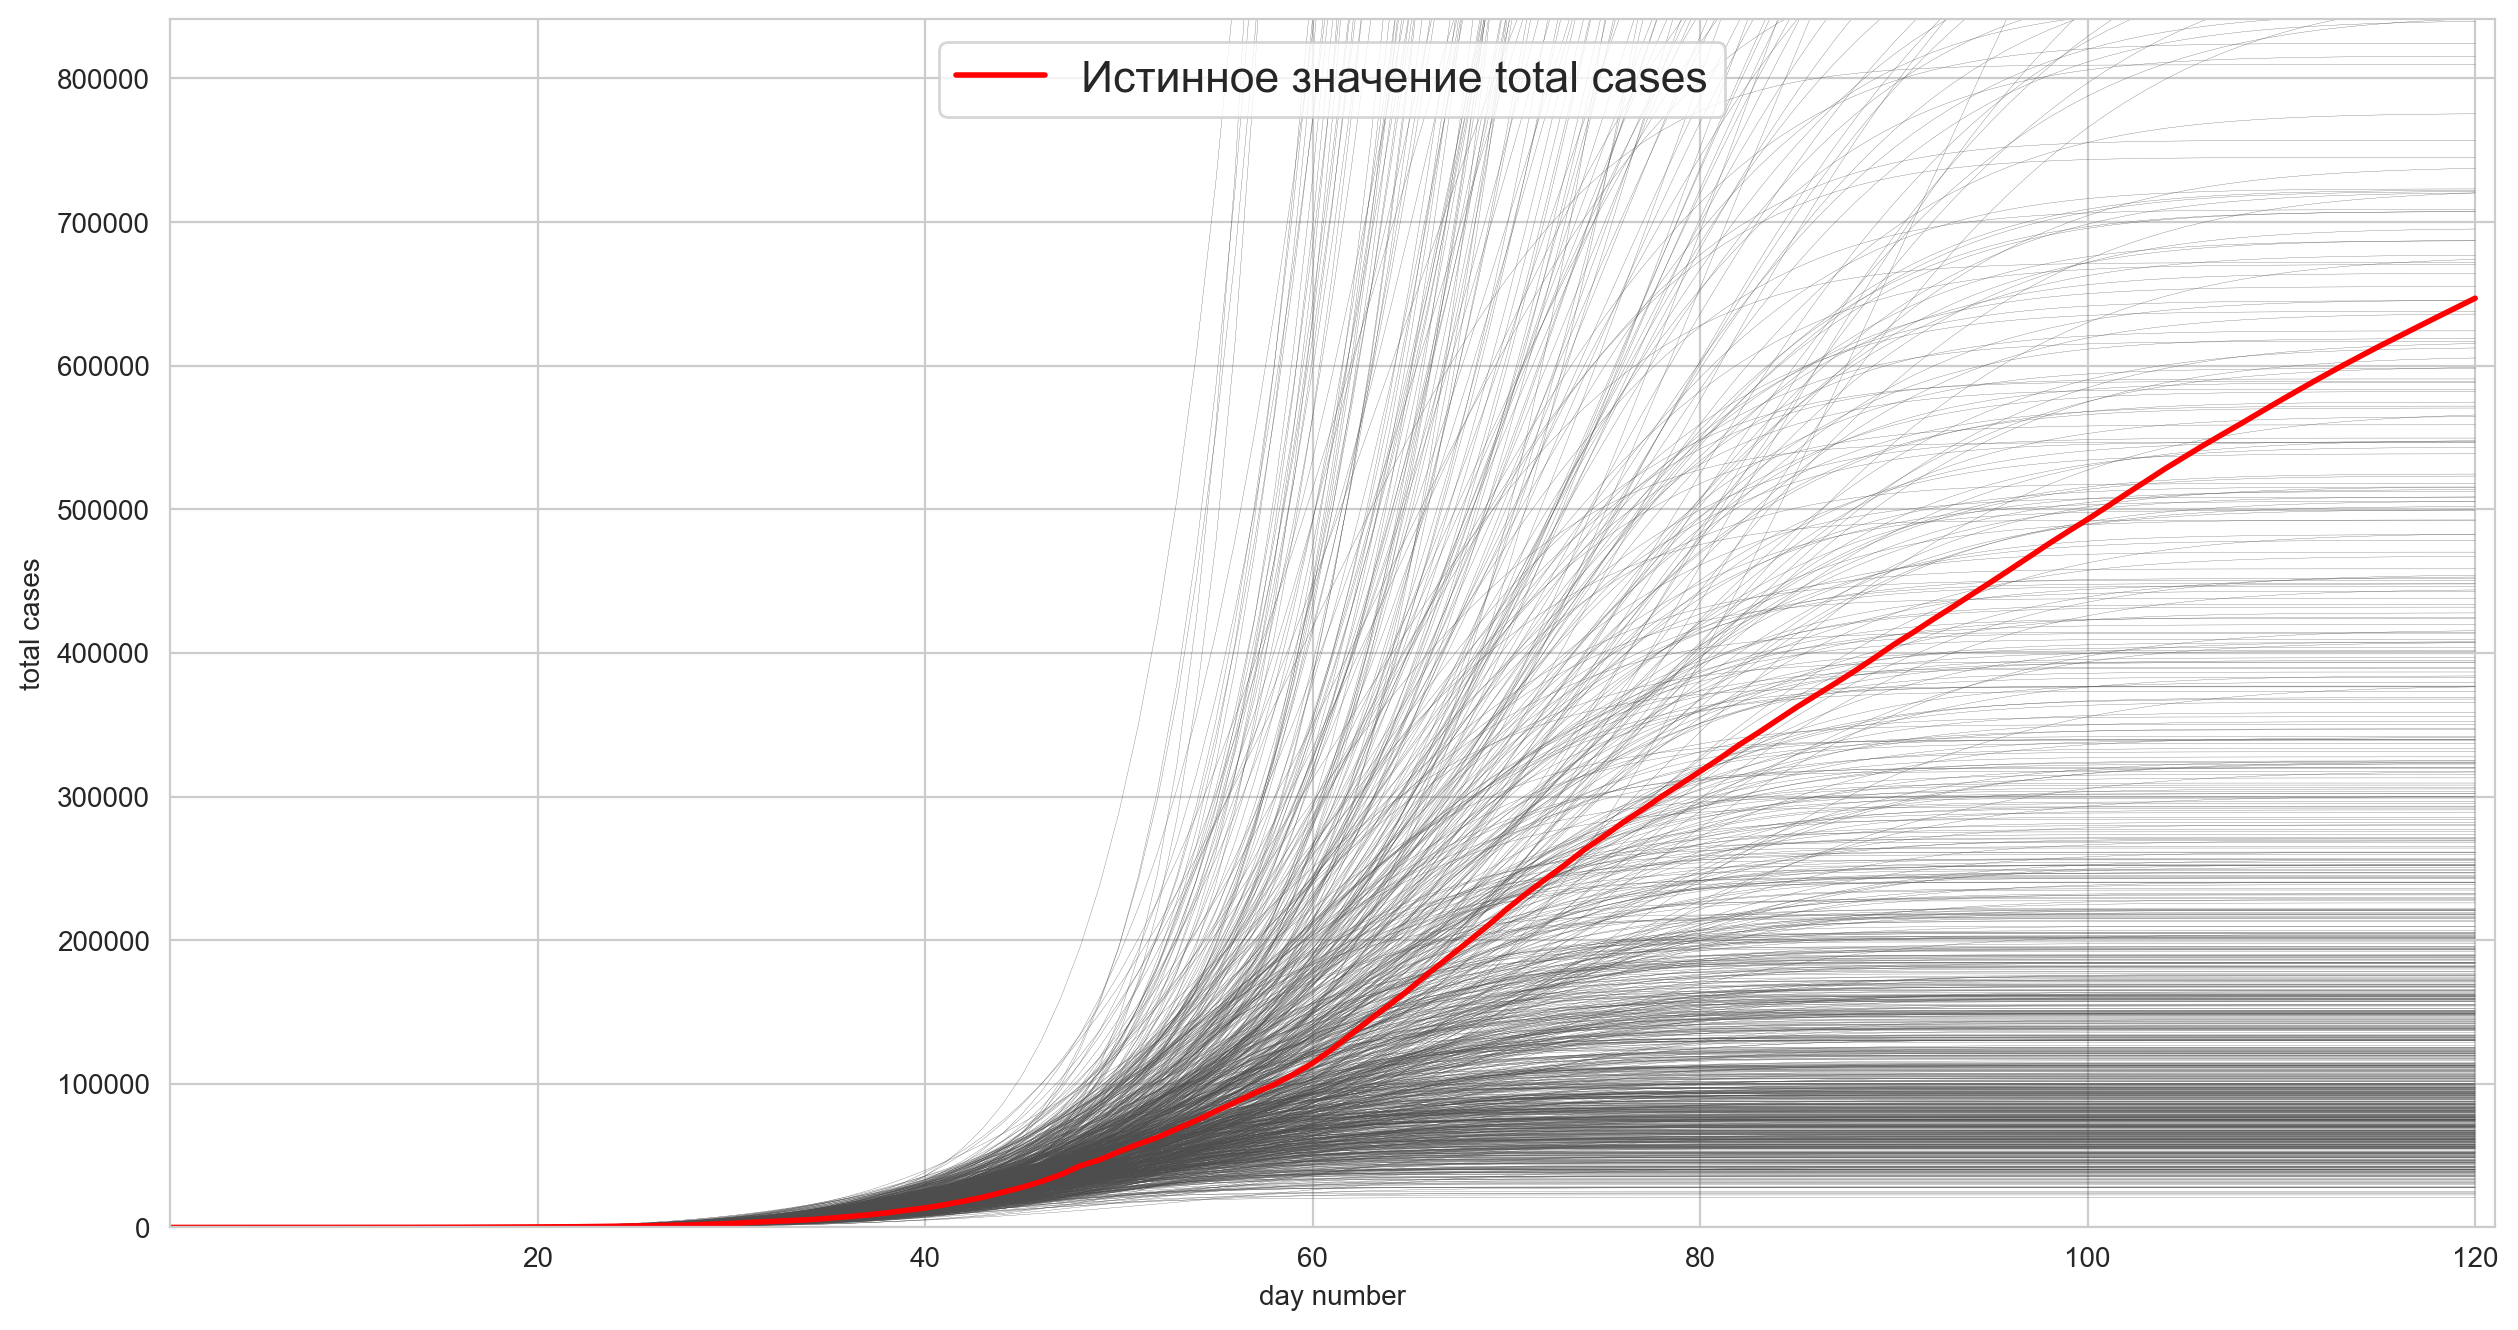

In [31]:
N = 1000
xs = np.array(df['day_number'][:120])
y = np.array(df['total_cases'][:120])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))
ax.set_ylim((0, max(y) * 1.3))

for model_params in np.random.multivariate_normal(mu_total_cases_post, sigma_total_cases_post, size=N):
    current_pred = model_params[0] * xs ** 2 + model_params[1] * xs + model_params[2]
    ax.plot(xs, restore_target(df, 'total_cases', current_pred), linewidth=.1, color="0.3")

ax.plot(xs, y, linewidth=2, label="Истинное значение total cases", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.xlabel('day number')
plt.ylabel('total cases')
plt.show()

Видим, что если использовать нашу модель для предсказания в будущем на долгий период, то а) предсказания будут заниженными б) диспрерсия предсказания огромна

Интересно посмотреть на график предсказания на всем временном интервале:

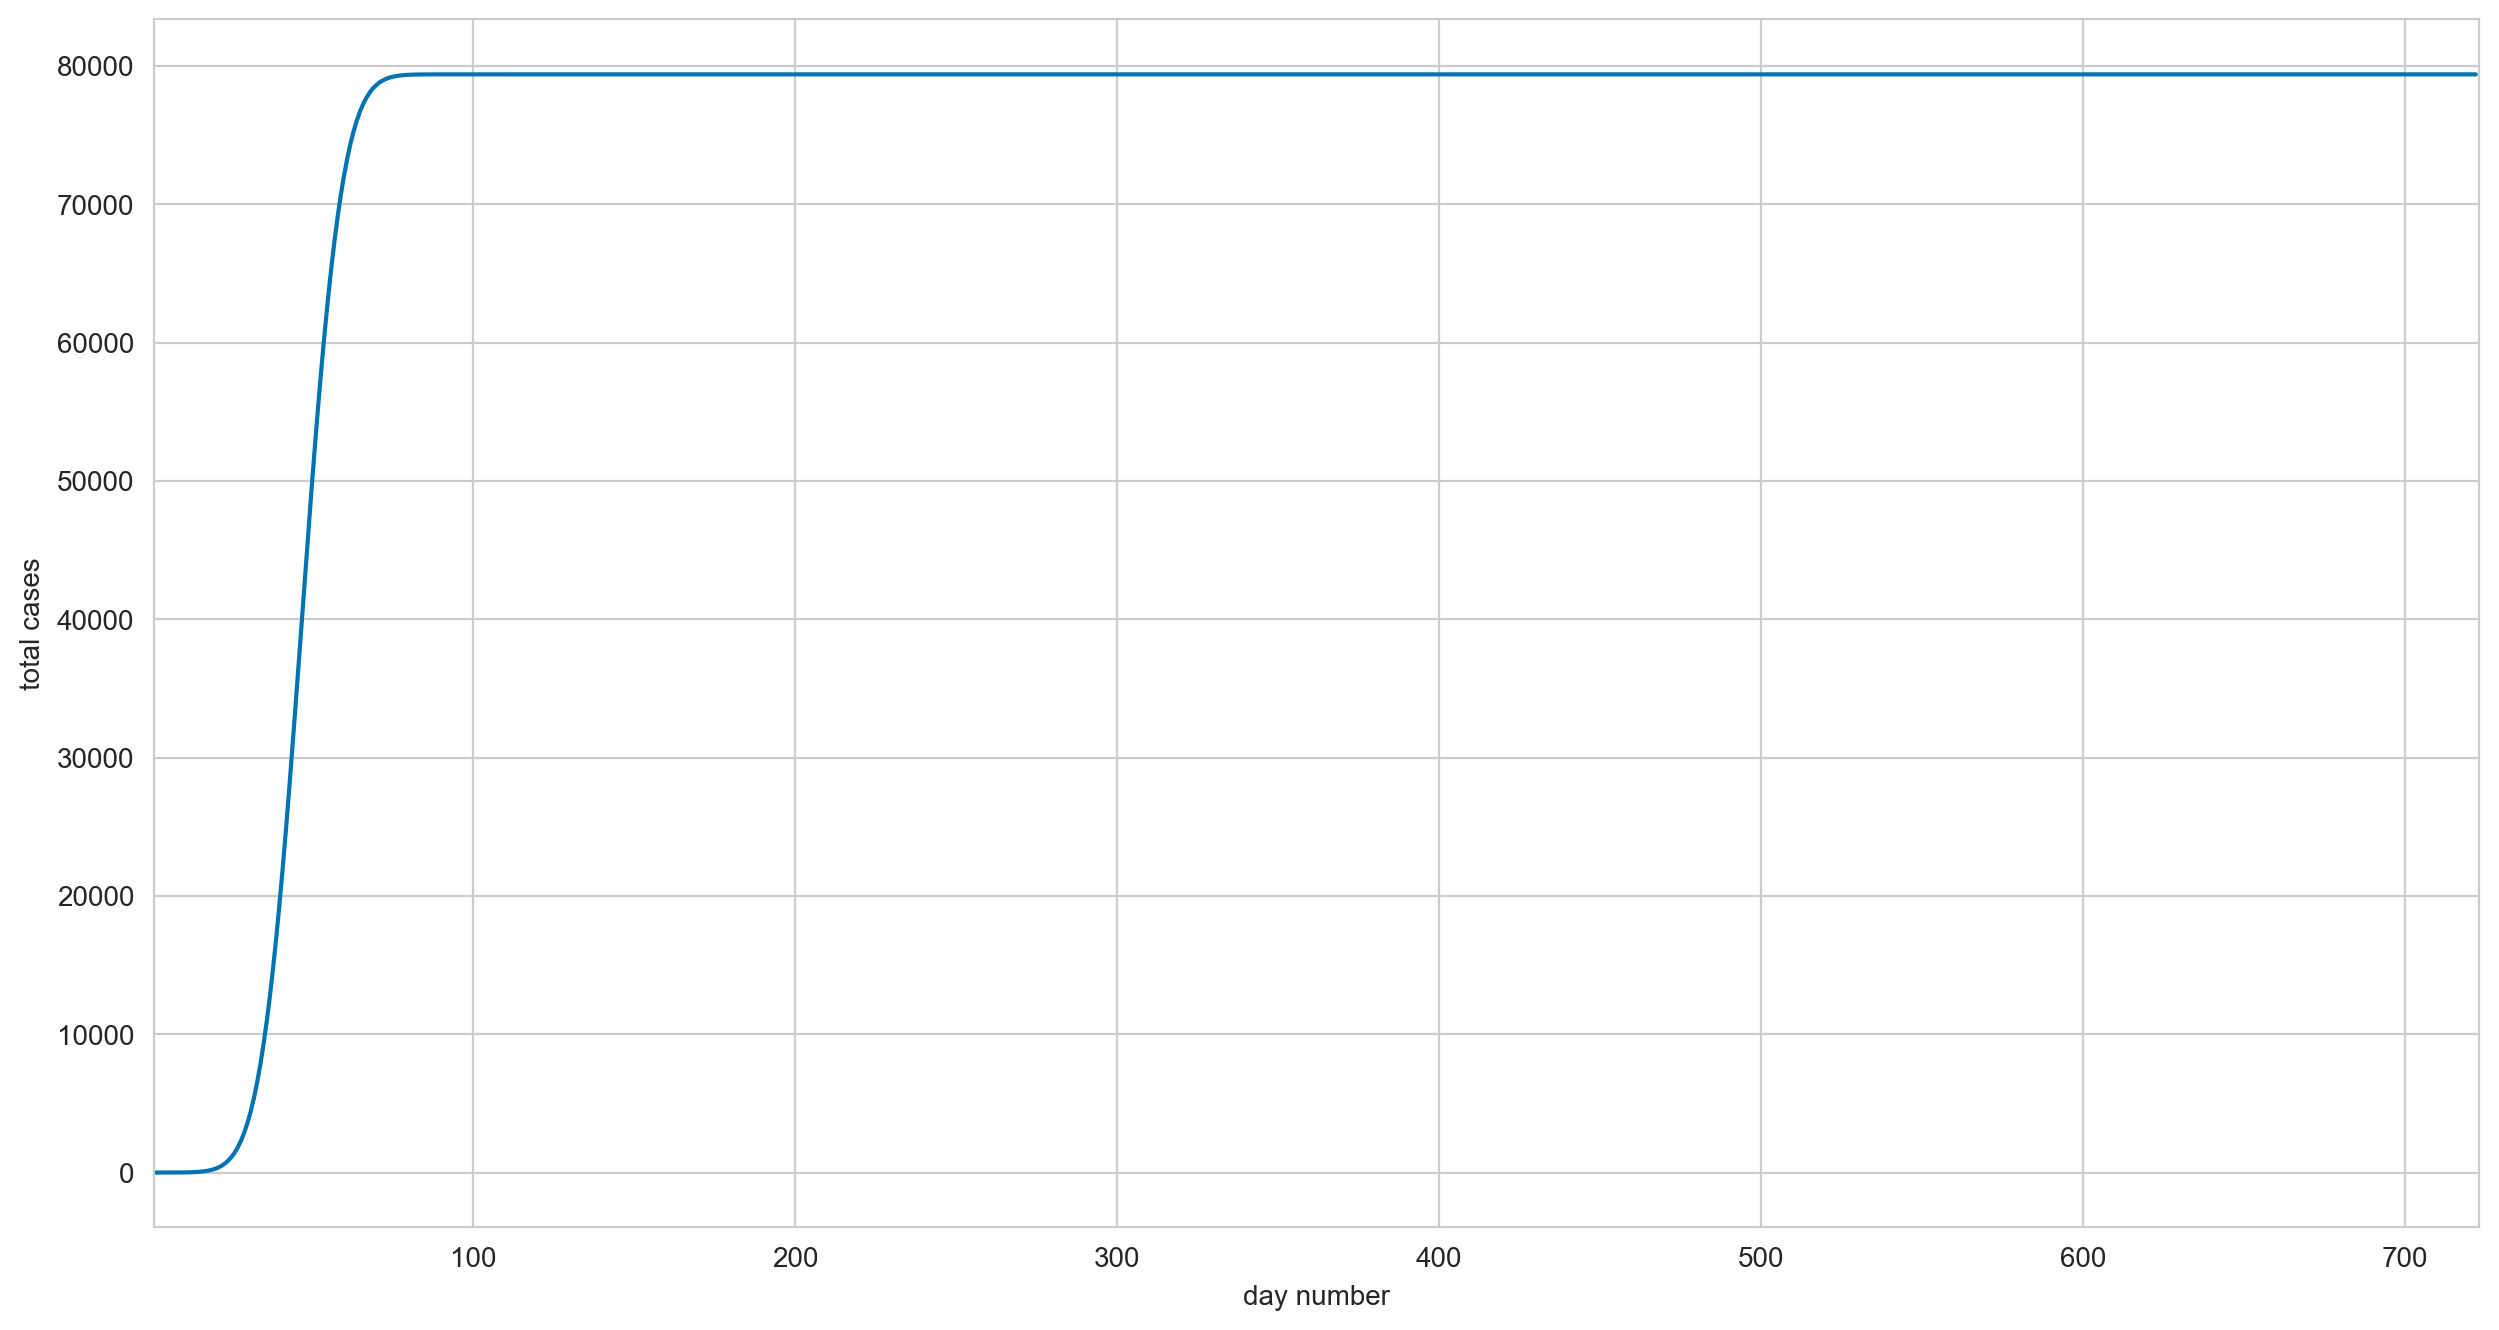

In [32]:
X_full = np.stack((df['day_number'] ** 2, df['day_number'], np.ones(df.shape[0])), axis=1)

xs = np.array(df['day_number'])

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1] + 1))

ax.plot(xs, restore_target(df, 'total_cases', lr_total_cases.predict(X_full)))

plt.xlabel('day number')
plt.ylabel('total cases')
plt.show()

Видим, что график выходит на асимптоту, не превышая 80 000 заболевших.

### Эмпирическое предсказательное распределение

In [33]:
def predict_distribution_at_day(predictions, day, target, range=None):
    y = predictions[:, day]
    plt.figure(figsize=figsize)
    plt.hist(y, 
             bins=100, 
             density=True, 
             range=None if range is None else tuple(np.quantile(y, range)))
    plt.grid(True)
    plt.xlabel(target)
    plt.title(f'{target} disctribution')
    return list(map(int, np.quantile(y, [0.1, 0.5, 0.9])))

In [34]:
predictions = []
days = np.array(df['day_number'])
for model_params in np.random.multivariate_normal(mu_total_cases_post, sigma_total_cases_post, size=10000):
    current_pred = model_params[0] * days ** 2 + model_params[1] * days + model_params[2]
    predictions.append(restore_target(df, 'total_cases', current_pred))
predictions = np.array(predictions)

Оптимистический прогноз на 01.05.2020: 47398 total cases
Средний прогноз на 01.05.2020: 101212 total cases
Пессимистический прогноз на 01.05.2020: 290792 total cases
Реальное значение на 01.05.2020: 114431 total cases


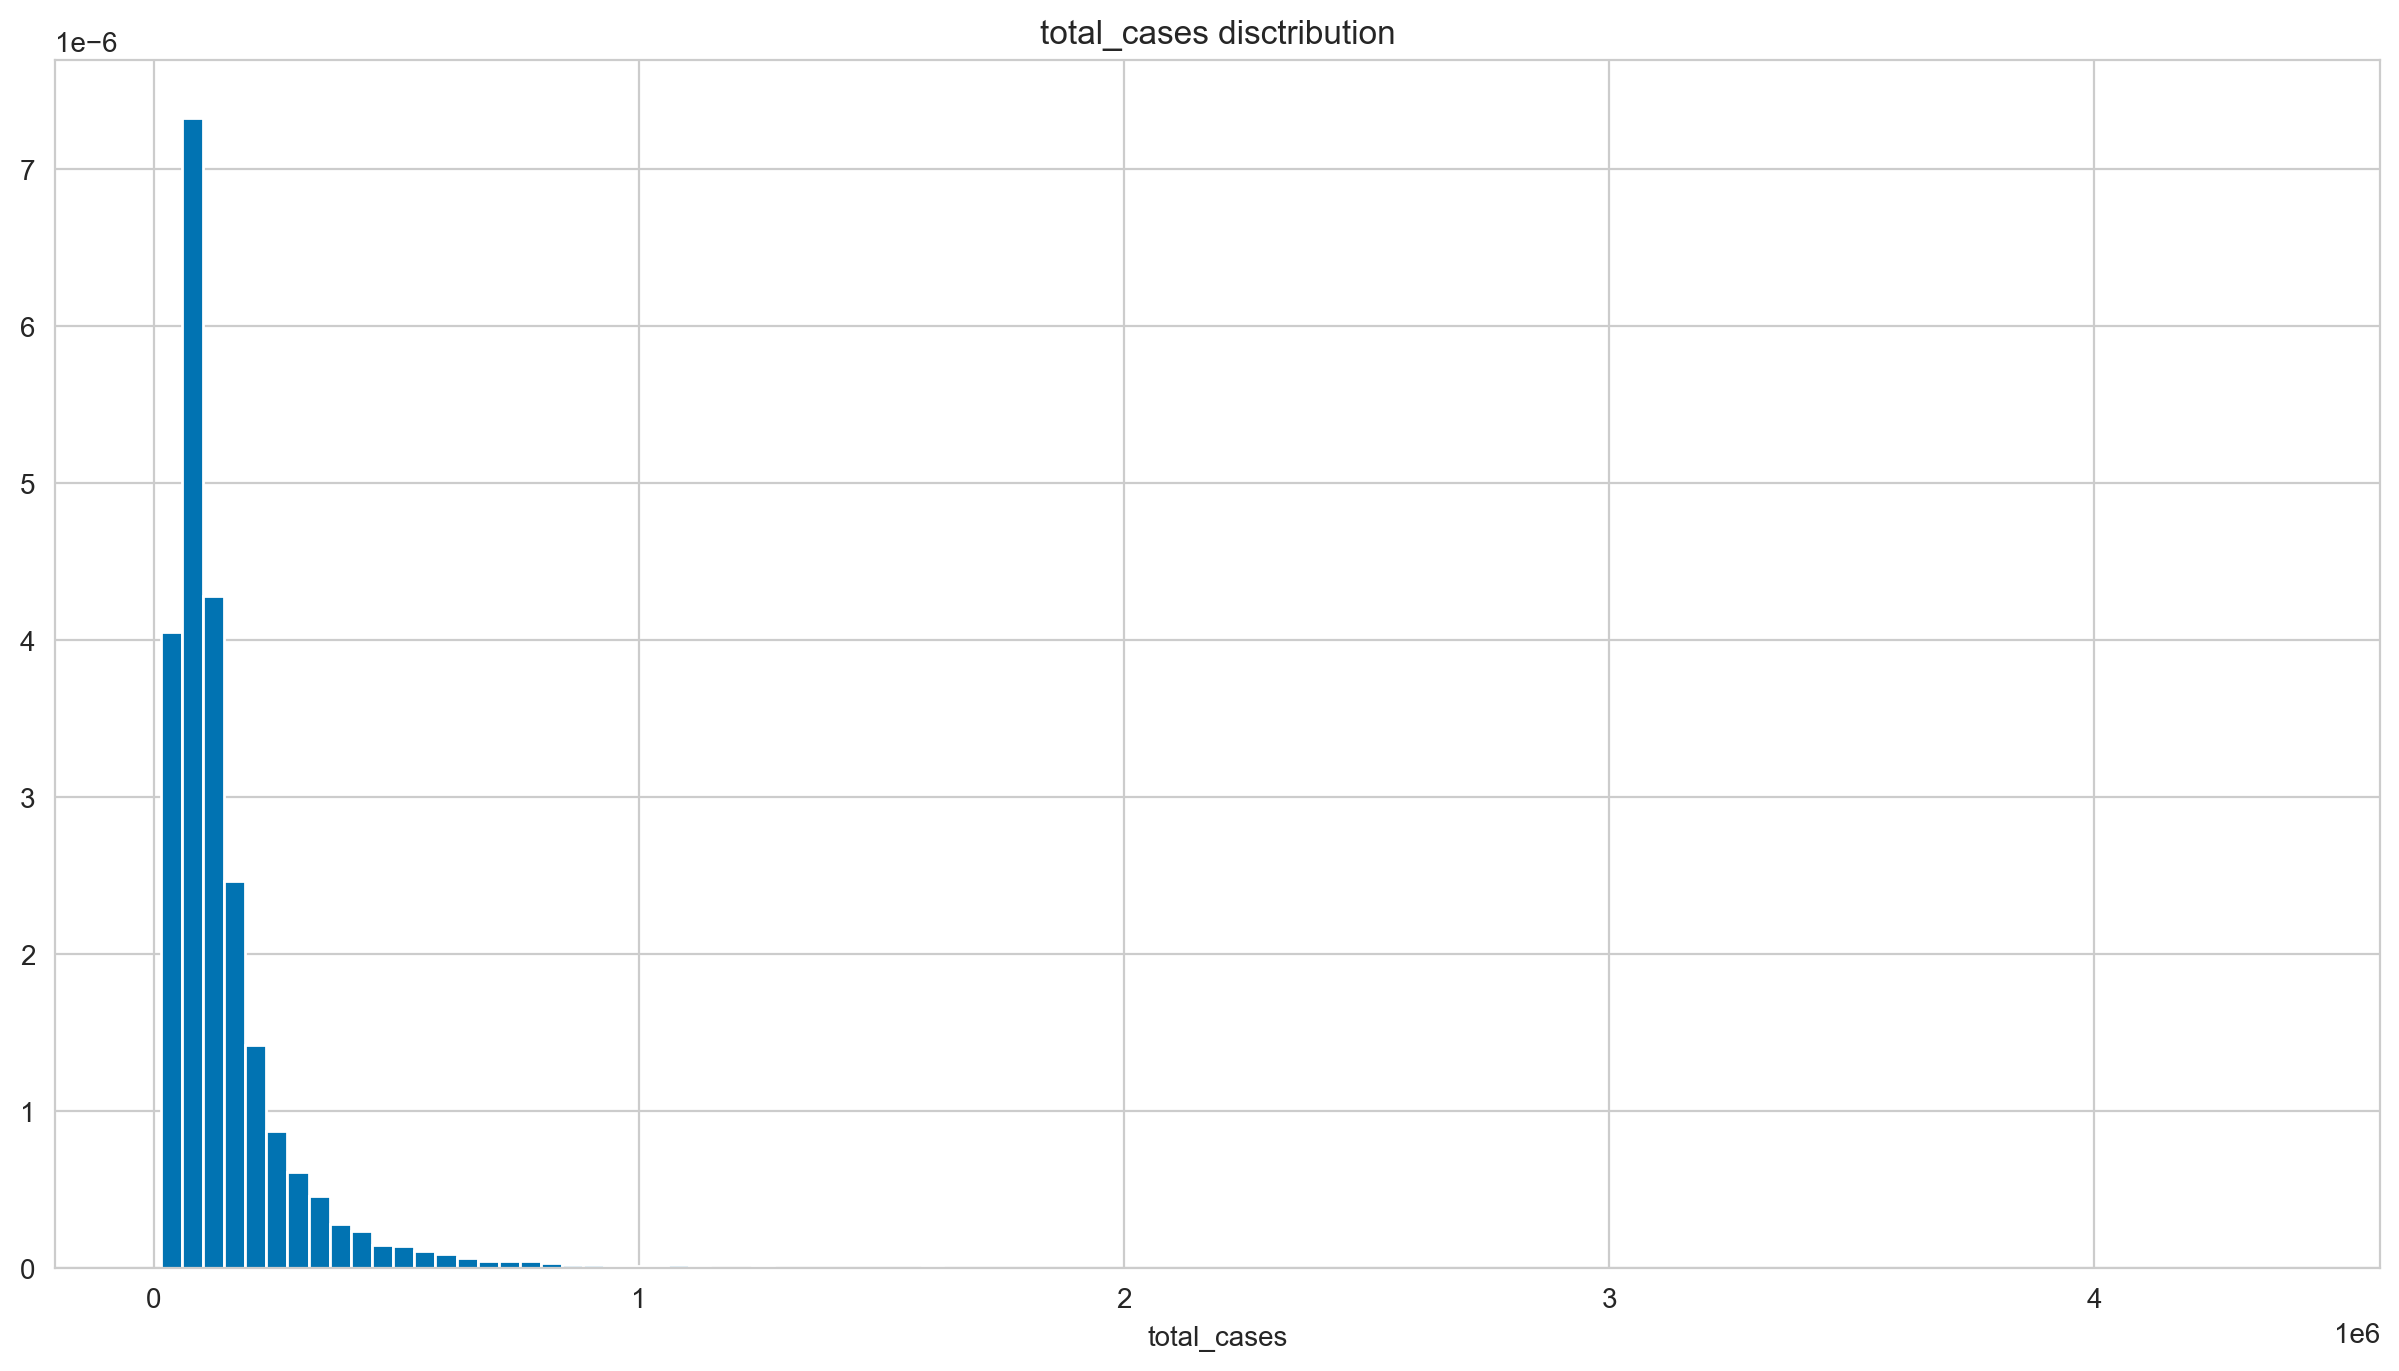

In [35]:
day = df[df['date'] == '2020-05-01']['day_number'].values[0]
prediction_stat = predict_distribution_at_day(predictions, day=day, target='total_cases')
print(f'Оптимистический прогноз на 01.05.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.05.2020: {prediction_stat[1]} total cases')
print(f'Пессимистический прогноз на 01.05.2020: {prediction_stat[2]} total cases')
print(f'Реальное значение на 01.05.2020: {int(df[df["date"] == "2020-05-01"]["total_cases"].values[0])} total cases')

Оптимистический прогноз на 01.06.2020: 52278 total cases
Средний прогноз на 01.06.2020: 144218 total cases
Пессимистический прогноз на 01.06.2020: 1522814 total cases
Реальное значение на 01.06.2020: 414328 total cases


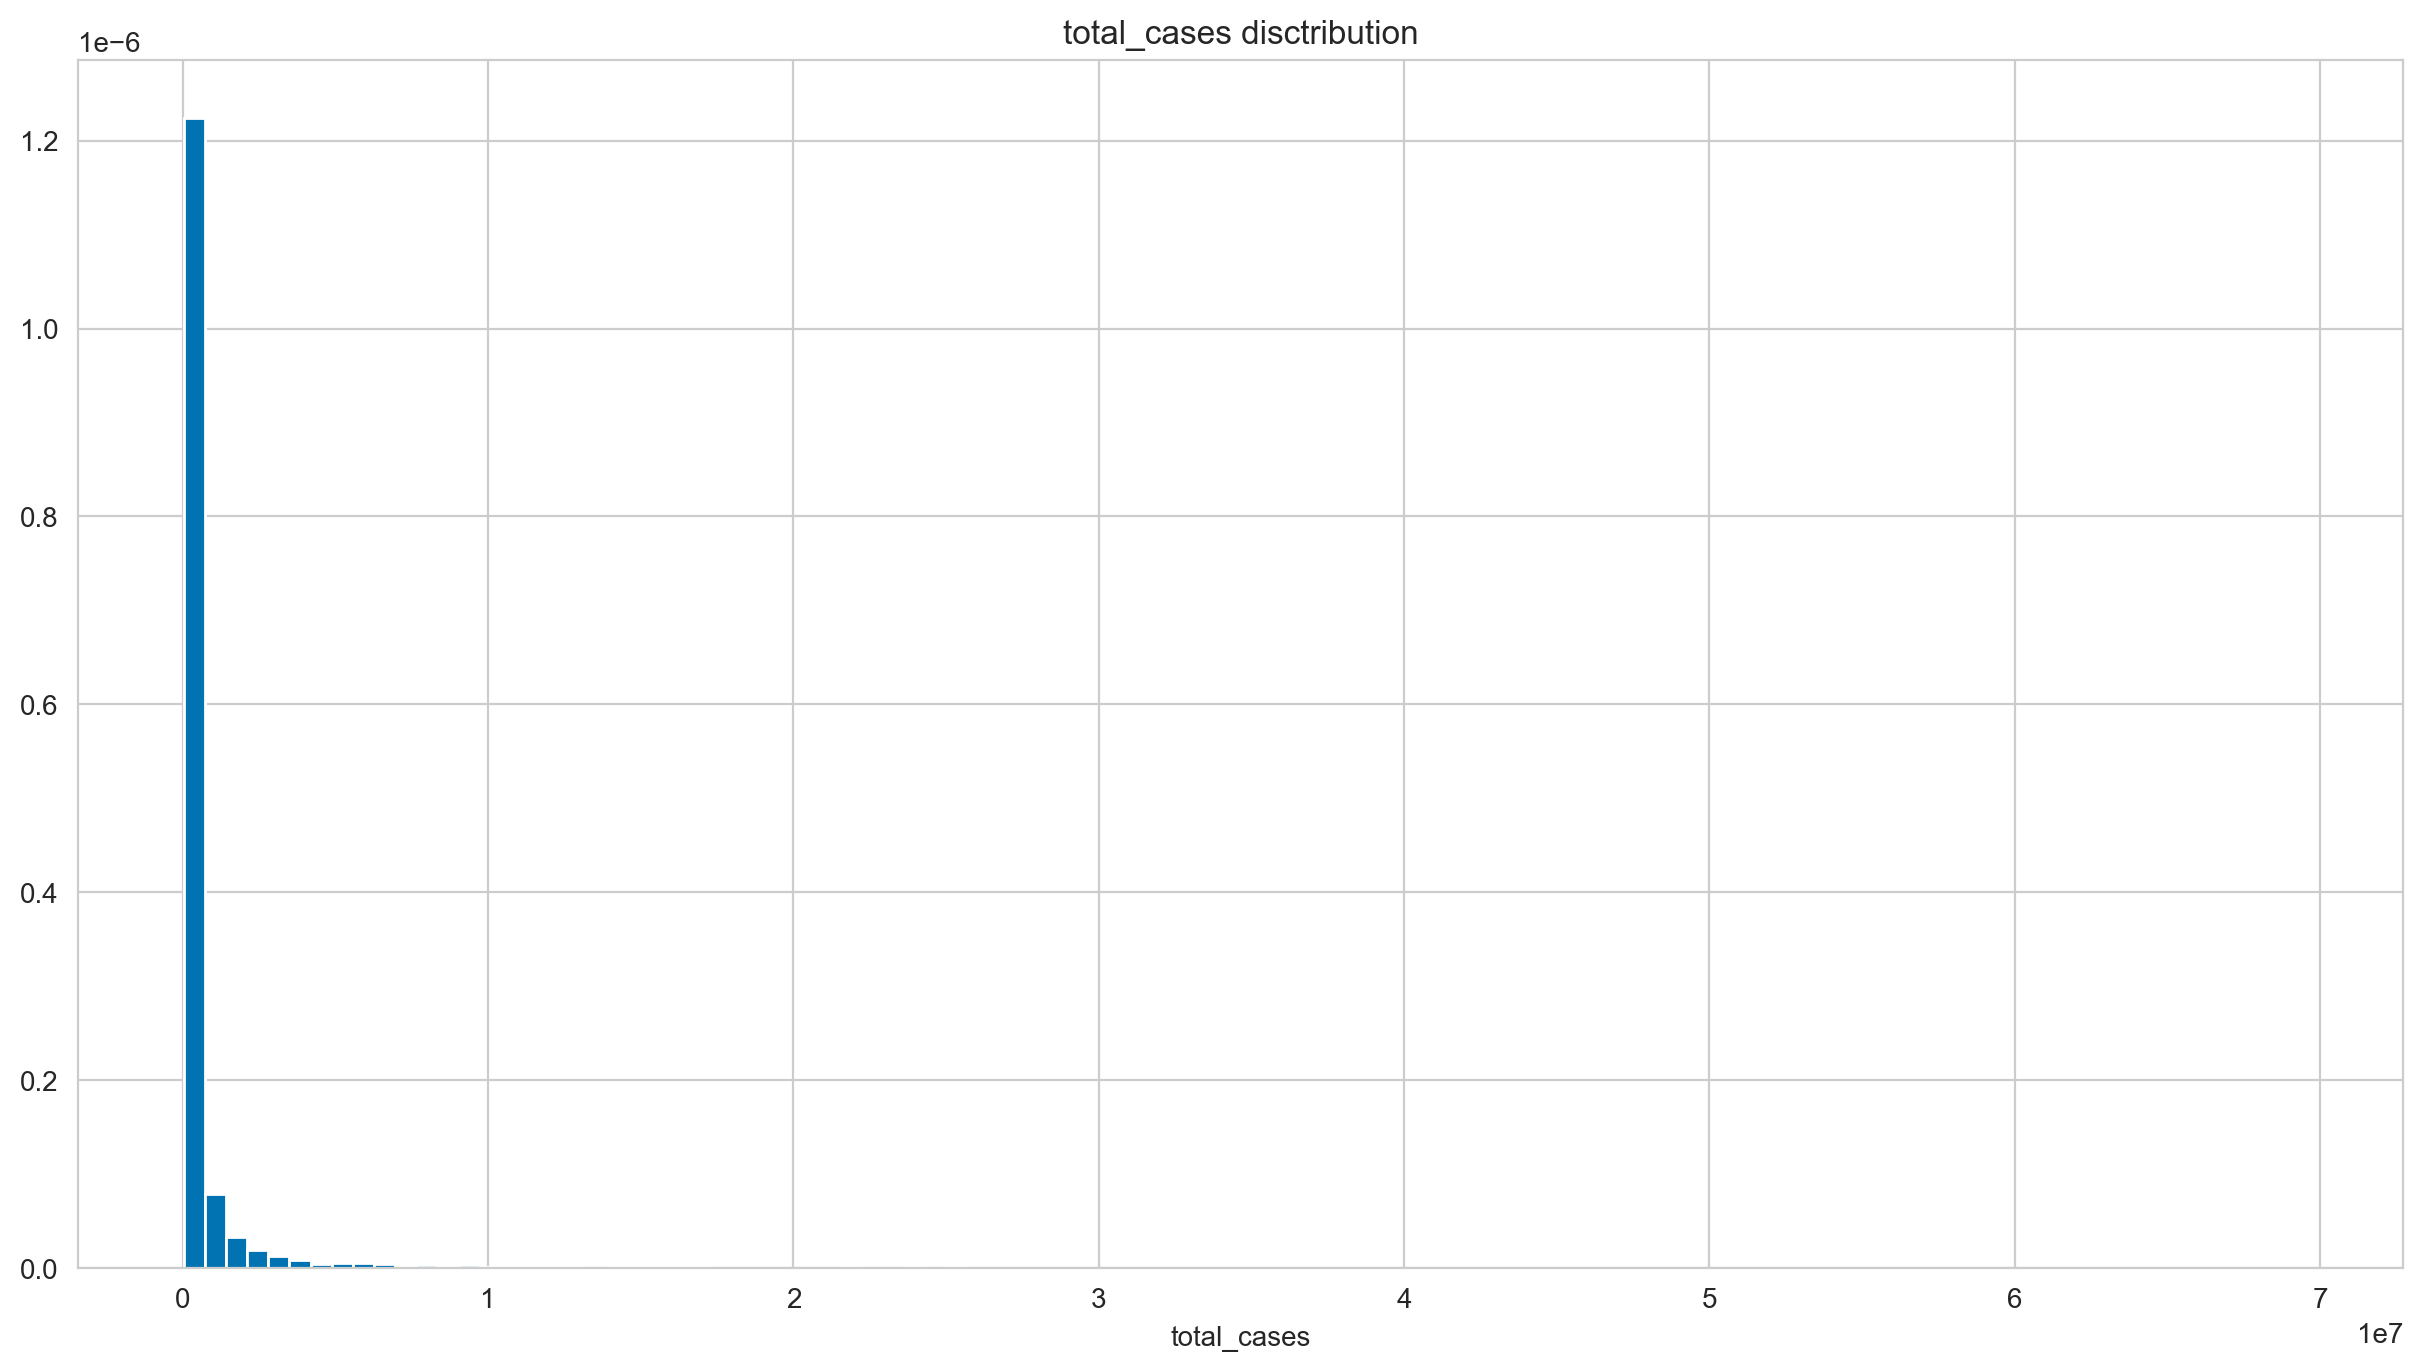

In [36]:
day = df[df['date'] == '2020-06-01']['day_number'].values[0]
prediction_stat = predict_distribution_at_day(predictions, day=day, target='total_cases', range=[0.01, 0.99])
print(f'Оптимистический прогноз на 01.06.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.06.2020: {prediction_stat[1]} total cases')
print(f'Пессимистический прогноз на 01.06.2020: {prediction_stat[2]} total cases')
print(f'Реальное значение на 01.06.2020: {int(df[df["date"] == "2020-06-01"]["total_cases"].values[0])} total cases')

Оптимистический прогноз на 01.09.2020: 52307 total cases
Средний прогноз на 01.09.2020: 144390 total cases
Пессимистический прогноз на 01.09.2020: 1910133 total cases
Реальное значение на 01.09.2020: 997072 total cases


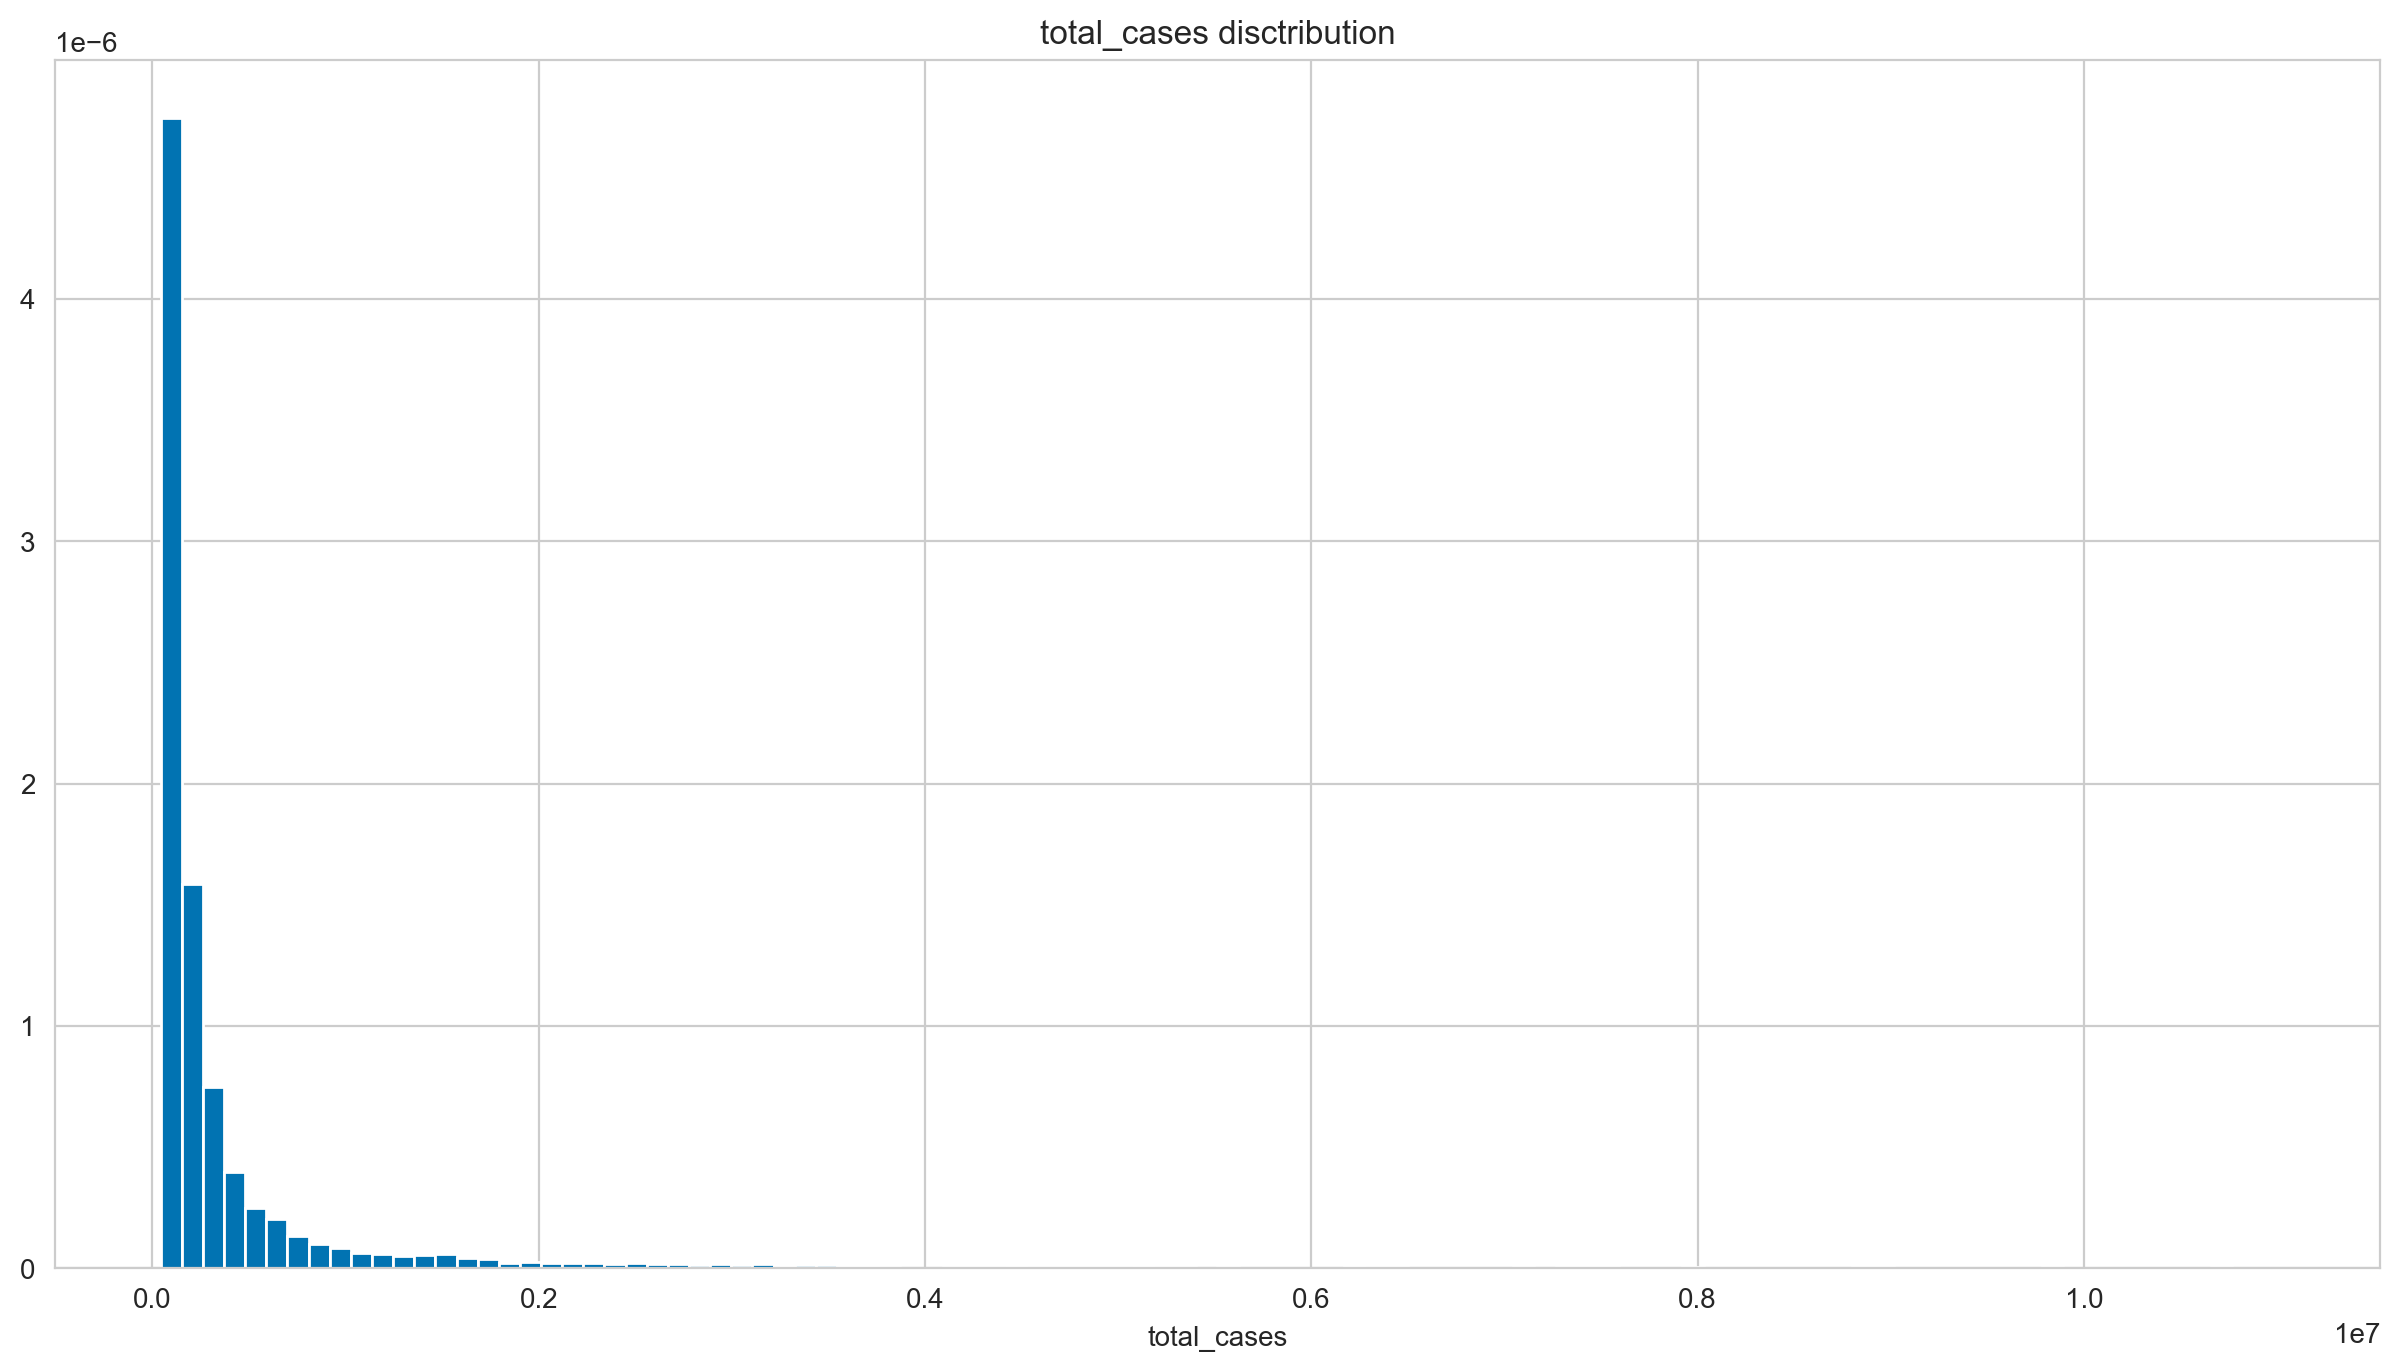

In [37]:
day = df[df['date'] == '2020-09-01']['day_number'].values[0]
prediction_stat = predict_distribution_at_day(predictions, day=day, target='total_cases', range=[0.05, 0.95])
print(f'Оптимистический прогноз на 01.09.2020: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.09.2020: {prediction_stat[1]} total cases')
print(f'Пессимистический прогноз на 01.09.2020: {prediction_stat[2]} total cases')
print(f'Реальное значение на 01.09.2020: {int(df[df["date"] == "2020-09-01"]["total_cases"].values[0])} total cases')

и также посмотрим на значение, близкое к нашему времени:

Оптимистический прогноз на 01.02.2022: 52307 total cases
Средний прогноз на 01.02.2022: 144390 total cases
Пессимистический прогноз на 01.02.2022: 1910133 total cases
Реальное значение на 01.02.2022: 11795059 total cases


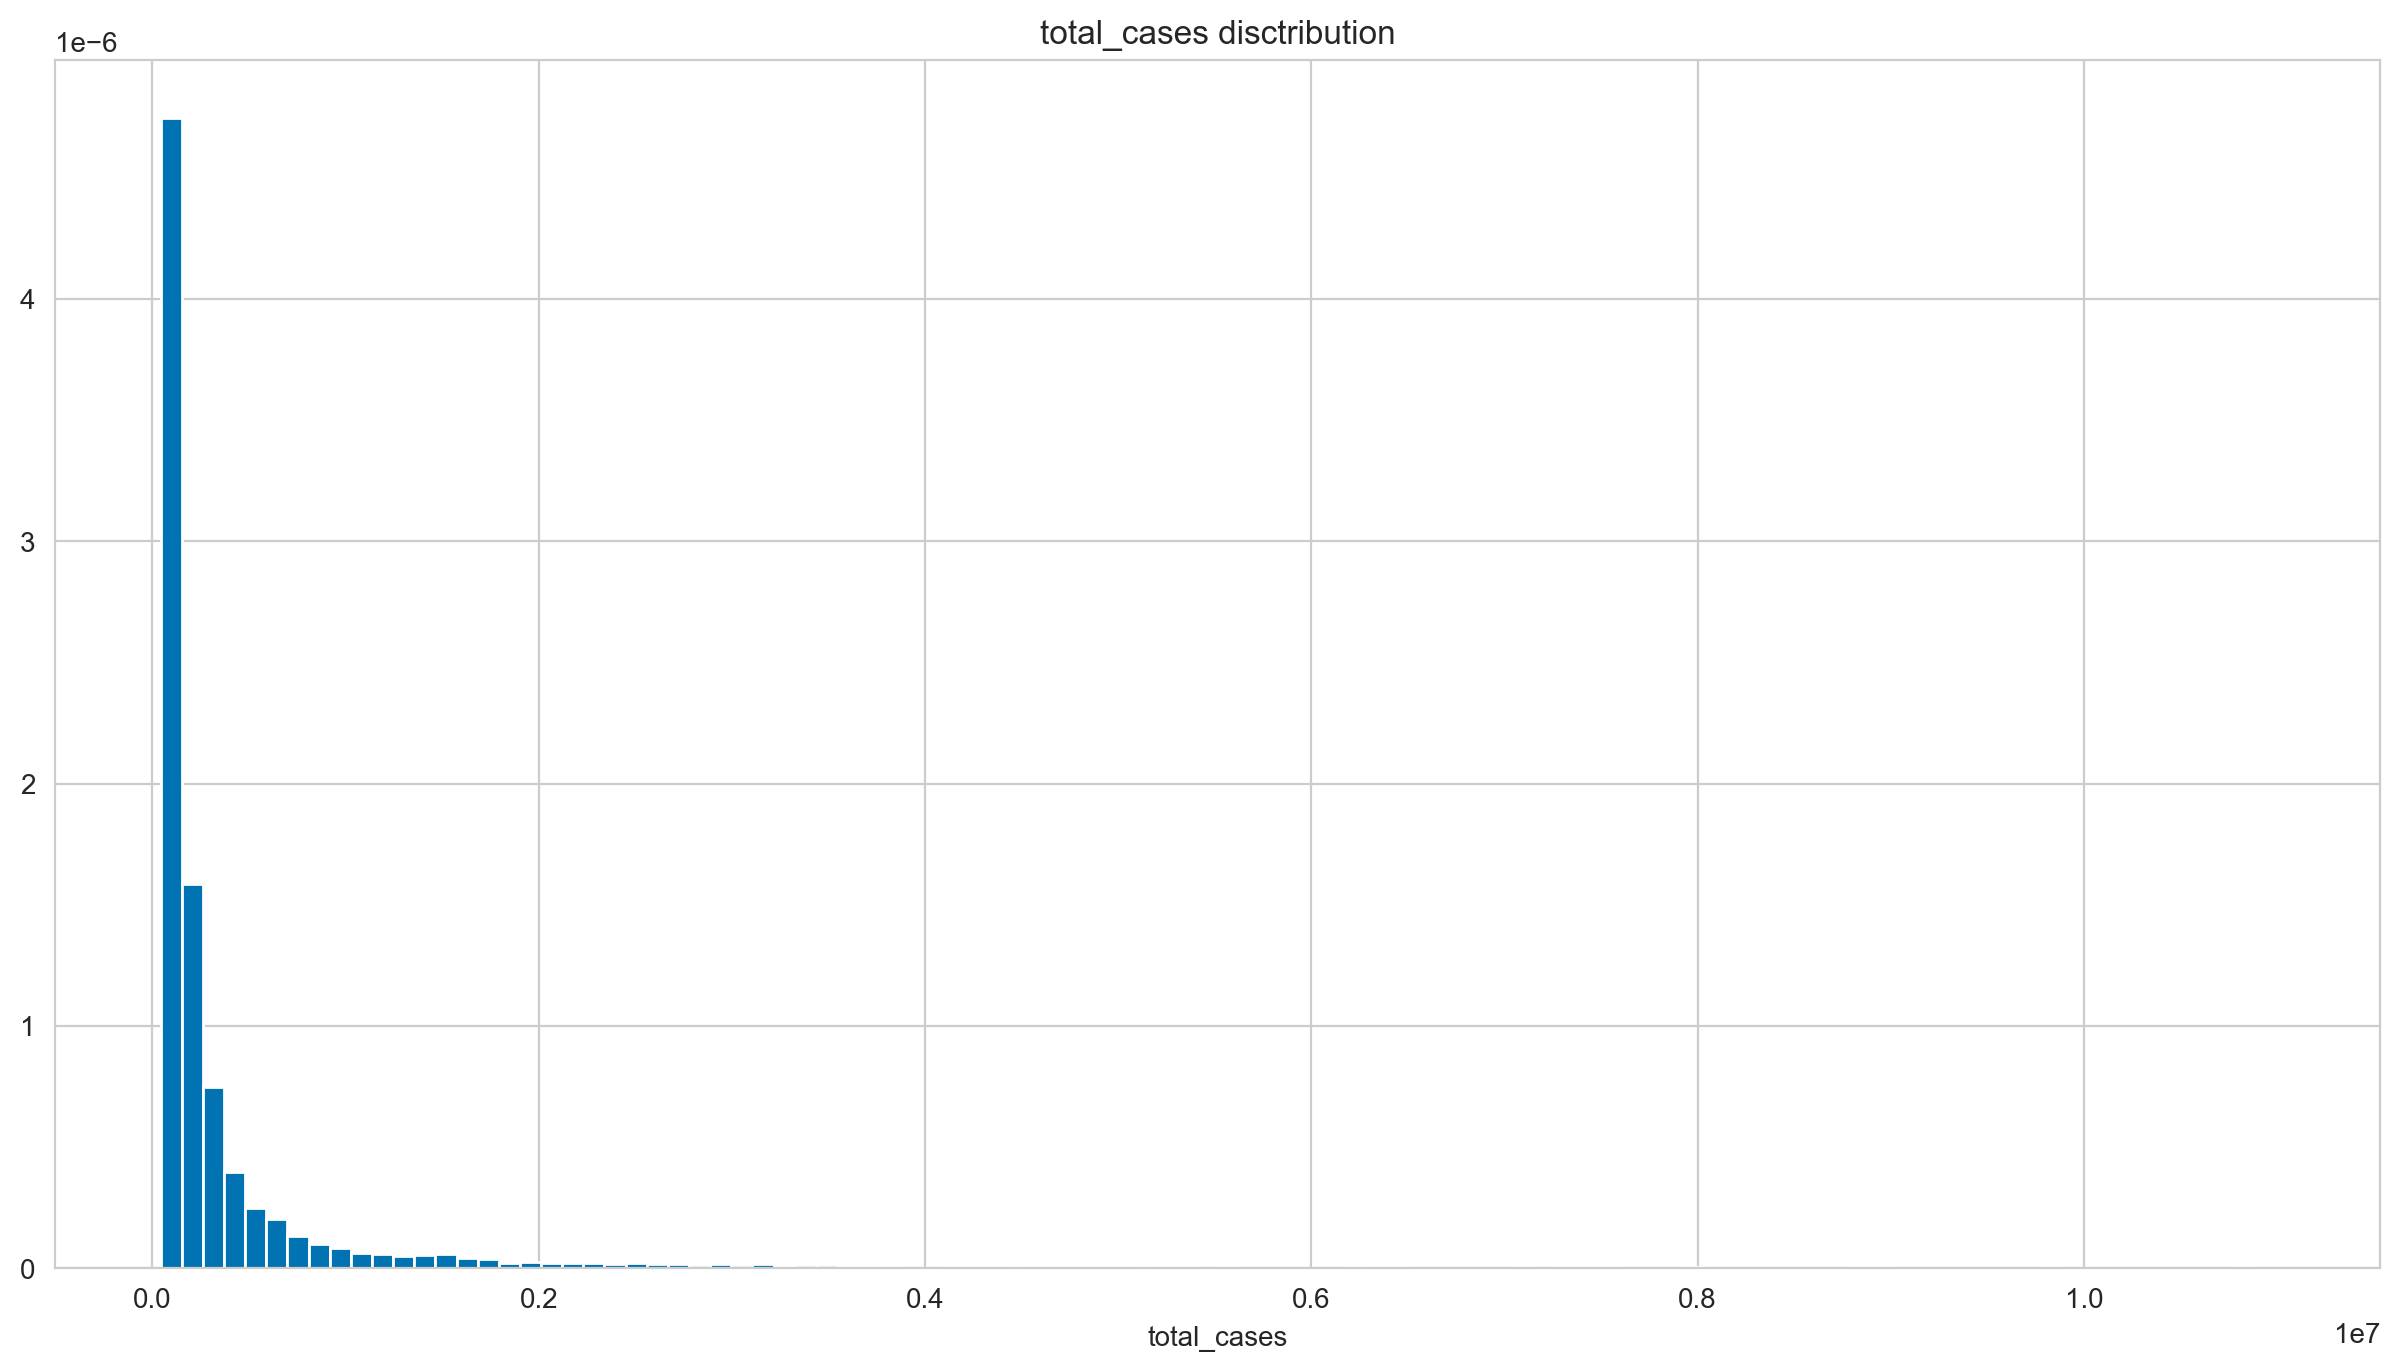

In [38]:
day = df[df['date'] == '2022-02-01']['day_number'].values[0]
prediction_stat = predict_distribution_at_day(predictions, day=day, target='total_cases', range=[0.05, 0.95])
print(f'Оптимистический прогноз на 01.02.2022: {prediction_stat[0]} total cases')
print(f'Средний прогноз на 01.02.2022: {prediction_stat[1]} total cases')
print(f'Пессимистический прогноз на 01.02.2022: {prediction_stat[2]} total cases')
print(f'Реальное значение на 01.02.2022: {int(df[df["date"] == "2022-02-01"]["total_cases"].values[0])} total cases')

Т.е. видим, что на 01.02.2022 даже пессимистический прогноз модели занижен во много раз.

Из вышеизложенного можно сделать вывод, что ни моделирование экспонентой, ни моделирование сигмоидой не позволяют строить сколько нибудь продолжительные прогнозы. Сигмоида показывает себя лучше, но тем не менее в обоих случаях дисперсия по мере увеличения горизонта прогноза растет очень сильно.